# Supplementary material on simulated data

# Imports and Functions

This was run with connection to a personal google drive. When running, please modify the direc argument below to save your files in the desired directory.

In [ ]:
######################
# importing packages #
######################

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import math
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

direc = '/content/drive/MyDrive/Work/ReLExD/NeurIPS2021/'

## Functions

### Data Simulation

In [ ]:
class Sim_Data(Dataset):
  """
  Simulate gene expression data regulated by transcription factors
  The assumed relationship between (log-transformed TPM) gene expression and TF activity is
  expression_i = sum_over_j(w_i_j * tf_j) with i representing genes and j TFs
  """
  def __init__(self, n_samples, n_genes, n_tfs, reg_matrix, noise):
    # initialize TF activities
    #self.tf_activities = np.random.gamma(shape=2.0, scale=.5,size=(n_samples,n_tfs))
    self.tf_activities = np.random.gamma(shape=1.0, scale=.5,size=(n_samples,n_tfs))
    # initialize global regulation matrix
    self.regulation_matrix = reg_matrix
    # simulate expression data
    self.data = np.zeros((n_samples, n_genes))
    for i in range(n_samples):
      for j in range(n_tfs):
        # expression data is derived from sum of regulation factor * tf activity over all TFs
        self.data[i,:] += self.regulation_matrix[:,j] * self.tf_activities[i,j]
      # add noise
      if noise != 0.0:
        self.data[i,:] += np.random.normal(scale=noise,size=n_genes)
    self.data[self.data < 0] = 0 # make sure that negative regulation does not result in negative values

  def __len__(self):
    return(self.data.shape[0])

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    sample = {'values': self.data[idx,:],
              'tf_activities': self.tf_activities[idx,:],
              'index': idx}
    return sample

def generate_regulation_matrix(size1, size2, fraction_connected):
  # initialize output matrix
  out = np.zeros((size1,size2))
  # calculate number of matrix entries that should be non-zero
  n_connected = round(fraction_connected * size1 * size2)
  n_negative = round(n_connected * 0.1) # make 10% of these negative regulation factors
  # choose matrix IDs for non-zero values
  ## there is a little room for error here, since I have not yet included check and substitution for duplicate positions
  position_x = np.random.choice(np.arange(size1),size=n_connected)
  position_y = np.random.choice(np.arange(size2),size=n_connected)
  # add regulation factors
  out[position_x[0:n_negative],position_y[0:n_negative]] = np.random.uniform(low=-1.0,high=-0.1,size=n_negative)
  out[position_x[n_negative:],position_y[n_negative:]] = np.random.uniform(low=0.1,high=1.0,size=(n_connected-n_negative))
  return out

def create_sparse_matrix(reg_mtrx, ratio):
  # set all values that are non-zero in the regulation matrix to 1
  binary_mtrx = reg_mtrx
  binary_mtrx[reg_mtrx != 0.0] = 1
  # if the sparse matrix is not supposed to be 100% correct, switch a given number of entries
  if ratio < 1:
    falsify = round((reg_mtrx.shape[0]*reg_mtrx.shape[1]) * (1-ratio))
    positions_x = np.random.choice(np.arange(reg_mtrx.shape[0]),size=falsify)
    positions_y = np.random.choice(np.arange(reg_mtrx.shape[1]),size=falsify)
    binary_mtrx[positions_x,positions_y] = 1 - binary_mtrx[positions_x,positions_y]
  binary_mtrx = torch.from_numpy(binary_mtrx).float()
  return binary_mtrx

### NN Layers and Classes

In [ ]:
class RepresentationLayer(torch.nn.Module):
  '''
  Implements a representation layer, that accumulates pytorch gradients.
  To update representation, the pytorch framework does not work well, so
  the module comes with it's own SGD update (self.update(lr,mom,...)).
  Do not forget to call zero_grad after an epoch
  '''
  def __init__(self, nrep, nsample,
                rep_activity=(1.,1.),      # Normal distribution mean and stddev
                norm=True                  # Normalize representation
              ):
    super(RepresentationLayer, self).__init__()
    self.nrep=nrep
    self.nsample=nsample
    self.mean, self.stddev = rep_activity[0],rep_activity[1]
    self.norm = norm
    self.init_rep(rep_activity[0],rep_activity[1])
    self.dz = None

  def init_rep(self,mean,stddev):
    # Generate random activities
    self.z = torch.nn.Parameter(torch.normal(mean,stddev,size=(self.nsample,self.nrep), requires_grad=True))
    self.clamp()

  def clamp(self):
    with torch.no_grad():
      if self.norm:
        self.z.clamp_(min=0)
        norm = 1./self.z.mean()
        self.z.mul_(norm)
      else:
        self.z.clamp_(min=0)

  def zero_grad(self):
    if self.z.grad is not None:
      self.z.grad.detach_()
      self.z.grad.zero_()

  def fix(self):
    self.z.requires_grad = False

  def unfix(self):
    self.z.requires_grad = True

  def forward(self, idx):
    if idx is None:
      return self.z
    else:
      return self.z[idx]

  # Index can be whatever it can be for a torch.tensor (e.g. tensor of idxs)
  def __getitem__(self,index):
    return self.h[index] # what is h?

  def update(self,idx,lr=0.001,mom=0.9,wd=None):
    device = self.z.device
    if self.dz is None:
      self.dz = torch.zeros(self.z.size()).to(device)
    with torch.no_grad():
      # Update z
      # dz(k,j) = sum_i grad(k,i) w(i,j) step(z(j))
      self.dz[idx] = self.dz[idx].mul(mom) - self.z.grad[idx].mul(lr)
      if wd is not None:
        self.dz[idx] -= wd*self.z[idx]
      self.z[idx] += self.dz[idx]
      self.clamp()

class SparseLinear(nn.Module):
  '''
  This class is based on the Linear class in PyTorch.
  The source code was taken from
  https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear

  Implements a sparse linear layer that masks the layer weights with a
  sparse matrix before matrix multiplication and activation function.
  For this, function sparse_linear is called in the forward function.
  '''
  __constants__ = ['in_features', 'out_features']
  in_features: int
  out_features: int
  weight: torch.Tensor
  # sparse connections as additional tensor to weights
  sparse: torch.Tensor

  def __init__(self, in_features: int, out_features: int, sparse: torch.Tensor, bias: bool = True):
      super(SparseLinear, self).__init__()
      self.in_features = in_features
      self.out_features = out_features
      self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
      # sparse tensor from input
      self.sparse = sparse
      if bias:
          self.bias = nn.Parameter(torch.Tensor(out_features))
      else:
          self.register_parameter('bias', None)
      self.reset_parameters()

  def reset_parameters(self):
      # I think the sparse tensor is not needed here
      nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5)) # was init
      if self.bias is not None:
          fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
          bound = 1 / math.sqrt(fan_in)
          nn.init.uniform_(self.bias, -bound, bound)
  
  def forward(self, input: torch.Tensor, use_sparse=True):
      return sparse_linear(input, self.weight, self.sparse, use_sparse, self.bias)

  def extra_repr(self):
      return 'in_features={}, out_features={}, bias={}'.format(
          self.in_features, self.out_features, self.bias is not None
      )

def sparse_linear(input, weight, sparse, use_sparse=True, bias=None):
  '''
  This function is based on the linear function in PyTorch.
  The source code was taken from
  https://github.com/pytorch/pytorch/pull/36810

  This is based on a simplified version of the nn.linear function.
  the weights are masked/multiplied with a binary sparse matrix before
  matrix multiplication of weights and layer input.
  '''
  tens_ops = (input, weight, sparse)
  if not torch.jit.is_scripting():
      if any([type(t) is not torch.Tensor for t in tens_ops]) and torch.overrides.has_torch_function(tens_ops):
          return torch.overrides.handle_torch_function(sparse_linear, tens_ops, input, weight, sparse, bias=bias)
  sparse_weight = weight * sparse
  output = input.matmul(sparse_weight.t())
  if bias is not None:
      output += bias
  ret = output
  
  return ret

class pretrained_Autoencoder(nn.Module):
    def __init__(self, in_dim, feats, decoder):
        super(pretrained_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim,feats),
            nn.LeakyReLU(negative_slope=0.01,inplace=True)) # prevent dying ReLU
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return(x)

class Autoencoder(nn.Module):
    def __init__(self, in_dim, feats, sparse_mtrx):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim,feats),
            nn.LeakyReLU(negative_slope=0.01,inplace=True)) # prevent dying ReLU
        self.decoder = nn.Sequential(
            SparseLinear(feats,in_dim, sparse_mtrx),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return(x)

class Enc2L_Autoencoder(nn.Module):
    def __init__(self, in_dim, feats, sparse_mtrx):
        super(Enc2L_Autoencoder, self).__init__()
        hidden_dim = round(feats+(in_dim-feats)/2)
        self.encoder = nn.Sequential(
            nn.Linear(in_dim,hidden_dim),
            nn.LeakyReLU(negative_slope=0.01,inplace=True), # prevent dying ReLU
            nn.Linear(hidden_dim,feats),
            nn.LeakyReLU(negative_slope=0.01,inplace=True))
        self.decoder = nn.Sequential(
            SparseLinear(feats,in_dim, sparse_mtrx),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return(x)

### Learning Rate Optimization

In [ ]:
def get_correlation(x, y):
  '''
  compute pearson correlation coefficient between 2 vectors
  '''
  pearson = np.corrcoef(x.flatten(), y.flatten())
  return pearson[0][1]

def train_representation(n_genes, n_tfs, n_samples, fraction_connected, noise, batch_size, num_epochs, lr, lr_rep, wd, plot=True):
  # initialize data
  regulation_matrix = generate_regulation_matrix(size1=n_genes, size2=n_tfs, fraction_connected=fraction_connected)
  train_data = Sim_Data(n_samples=n_samples, n_genes=n_genes, n_tfs=n_tfs, reg_matrix=regulation_matrix, noise=noise)
  train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True)
  sparse_mtrx = create_sparse_matrix(regulation_matrix, 1).to(device)

  # initialize representation and decoder
  representation = RepresentationLayer(n_tfs,n_samples).to(device)
  decoder = torch.nn.Sequential(
    SparseLinear(n_tfs,n_genes,sparse_mtrx),
    torch.nn.ReLU(inplace=True)).to(device)
  decoder_optimizer = torch.optim.Adam(decoder.parameters(),
                                      lr=lr,
                                      weight_decay=wd)
  criterion = torch.nn.MSELoss(reduction='mean')

  # save loss development
  history_epoch = []
  history_loss = []
  history_inout_corr = []
  history_rep_corr = []
  history_weight_corr = []

  # train decoder and representation
  for epoch in range(num_epochs):
    # initialize metrics
    batch_loss = 0
    running_corr = 0
    running_x_corr = 0
    representation.zero_grad()
    for data in train_loader:
      # get input data and indices
      x = data['values'].float().to(device)
      idx = data['index'].to(device)
      decoder_optimizer.zero_grad()
      # get representation for indices
      z = representation(idx)
      running_corr += get_correlation(data['tf_activities'],z.detach().numpy())
      # get output from representation
      y = decoder(z)
      running_x_corr += get_correlation(x.detach().numpy(),y.detach().numpy())
      # compute loss
      loss = criterion(y,x)
      batch_loss += loss.item()
      loss.backward()
      # update representation
      representation.update(idx,lr=lr_rep*x.shape[0]*regulation_matrix.shape[1],mom=0.9)
      decoder_optimizer.step()
    # extend history
    history_epoch.append(epoch)
    history_loss.append(batch_loss/len(train_loader))
    history_inout_corr.append(running_x_corr/len(train_loader))
    history_rep_corr.append(running_corr/len(train_loader))
    weights_layer = decoder[0].weight.clone().detach().numpy()
    correlation = get_correlation(regulation_matrix, weights_layer)
    history_weight_corr.append(correlation)

  df = pd.DataFrame({'epoch':history_epoch,
                          'loss': history_loss,
                          'x_y_correlation':history_inout_corr,
                          'representation_correlation': history_rep_corr,
                          'weight_correlation': history_weight_corr,
                     'lr':lr,
                     'lr_rep':lr_rep})
  
  if plot:
    fig, ax = plt.subplots(ncols=4, figsize=(20,5))
    sns.lineplot(data=df, x='epoch', y='loss', ax=ax[0])
    ax[0].set_yscale('log')
    sns.lineplot(data=df, x='epoch', y='x_y_correlation', ax=ax[1])
    sns.lineplot(data=df, x='epoch', y='representation_correlation', ax=ax[2])
    sns.lineplot(data=df, x='epoch', y='weight_correlation', ax=ax[3])
    plt.tight_layout()
    plt.show()
  
  return df

def train_autoencoder(n_genes, n_tfs, n_samples, fraction_connected, noise, batch_size, num_epochs, lr, wd, plot=True):
  # generate data
  regulation_matrix = generate_regulation_matrix(size1=n_genes, size2=n_tfs, fraction_connected=fraction_connected)
  train_data = Sim_Data(n_samples=n_samples, n_genes=n_genes, n_tfs=n_tfs, reg_matrix=regulation_matrix, noise=noise)
  test_data = Sim_Data(n_samples=100, n_genes=n_genes, n_tfs=n_tfs, reg_matrix=regulation_matrix, noise=noise)
  train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=True)
  sparse_mtrx = create_sparse_matrix(regulation_matrix, 1).to(device)

  # initialize model
  model = Autoencoder(in_dim=n_genes, feats=n_tfs, sparse_mtrx=sparse_mtrx)
  optimizer = torch.optim.Adam(model.parameters(),
                                      lr=lr,
                                      weight_decay=wd)
  criterion = torch.nn.MSELoss(reduction='mean')

  # save loss development
  history_epoch = []
  history_loss = []
  history_test_loss = []
  history_inout_corr = []
  history_rep_corr = []
  history_weight_corr = []

  # train encoder or full AE
  encoder = nn.Sequential(*list(model.children())[0])
  decoder_temp = nn.Sequential(*list(model.children())[1])
  for epoch in range(num_epochs):
    # initialize metrics
    batch_loss = 0
    for data in train_loader:
      # get input data and indices
      x = data['values'].float().to(device)
      optimizer.zero_grad()
      # get output
      y = model(x)
      # compute loss
      loss = criterion(y,x)
      batch_loss += loss.item()
      loss.backward()
      optimizer.step()
    optimizer.zero_grad()
    batch_test_loss = 0
    running_corr = 0
    running_x_corr = 0
    for test in test_loader:
      x = test['values'].float().to(device)
      z = encoder(x)
      running_corr += get_correlation(test['tf_activities'],z.detach().numpy())
      y = model(x)
      running_x_corr += get_correlation(x.detach().numpy(),y.detach().numpy())
      loss = criterion(y,x)
      batch_test_loss += loss.item()
    # extend history
    history_epoch.append(epoch)
    history_loss.append(batch_loss/len(train_loader))
    history_test_loss.append(batch_test_loss/len(test_loader))
    history_inout_corr.append(running_x_corr/len(test_loader))
    history_rep_corr.append(running_corr/len(test_loader))
    weights_layer = decoder_temp[0].weight.clone().detach().numpy()
    correlation = get_correlation(regulation_matrix, weights_layer)
    history_weight_corr.append(correlation)

  df = pd.DataFrame({'epoch':history_epoch,
                          'loss': history_loss,
                          'x_y_correlation':history_inout_corr,
                          'representation_correlation': history_rep_corr,
                          'weight_correlation': history_weight_corr,
                     'loss_type': 'train',
                     'lr':lr})
  df = df.append(pd.DataFrame({'epoch':history_epoch,
                          'loss': history_test_loss,
                          'x_y_correlation':history_inout_corr,
                          'representation_correlation': history_rep_corr,
                          'weight_correlation': history_weight_corr,
                     'loss_type': 'test',
                     'lr':lr}))
  
  if plot:
    fig, ax = plt.subplots(ncols=4, figsize=(20,5))
    sns.lineplot(data=df, x='epoch', y='loss', hue='loss_type', ax=ax[0])
    ax[0].set_yscale('log')
    sns.lineplot(data=df[df['loss_type'] == 'test'], x='epoch', y='x_y_correlation', ax=ax[1])
    sns.lineplot(data=df[df['loss_type'] == 'test'], x='epoch', y='representation_correlation', ax=ax[2])
    sns.lineplot(data=df[df['loss_type'] == 'test'], x='epoch', y='weight_correlation', ax=ax[3])
    plt.tight_layout()
    plt.show()
  
  return df

### Training Wrappers

In [ ]:
def get_weights(model,child_number,get_tensor=True):
  '''
  extract weights from NN layers,
  either as tensor or as detached array
  '''
  count = 0
  for child in model.children():
      if count == child_number:
          if get_tensor:
              return child[0].weight
          else:
              return child[0].weight.clone().detach().numpy()
      count += 1

def get_correlation(x, y):
  '''
  compute pearson correlation coefficient between 2 vectors
  '''
  pearson = np.corrcoef(x.flatten(), y.flatten())
  return pearson[0][1]

def set_random_seed(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
  
def alpha_d(in_dim, hidden, samples, weights):
  # compute decoder load
  return (samples * in_dim) / (weights + samples * hidden)

def alpha_e(hidden, samples, weights):
  # compute encoder load
  return (samples * hidden) / weights

def train_representation_alone(decoder, decoder_optimizer, representation, test_representation, sim_loader, test_loader, criterion, lr_rep, regulation_matrix, num_epochs, plot=True):
  '''
  wrapper function for training representation and decoder
  The output is the trained decoder and the training history
  '''
  # save loss development
  history_epoch = []
  history_loss = []
  history_test_loss = []
  history_inout_corr = []
  history_rep_corr = []
  history_rep_test_corr = []
  history_weight_corr = []

  n_tfs = regulation_matrix.shape[1]
  # train decoder and representation
  for epoch in range(num_epochs):
    # initialize accumulating metric
    batch_loss = 0
    running_corr = 0
    # set representation gradients to zero
    representation.zero_grad()
    # update decoder with all training samples
    for data in sim_loader:
      x = data['values'].float().to(device)
      idx = data['index'].to(device)
      # set decoder gradients to zero
      decoder_optimizer.zero_grad()
      # extract representation for batch
      z = representation(idx)
      # get decoder output and compute loss
      running_corr += get_correlation(data['tf_activities'],z.detach().numpy())
      y = decoder(z)
      loss = criterion(y,x)
      batch_loss += loss.item()
      loss.backward()
      # update representation
      representation.update(idx,lr=lr_rep*x.shape[0]*n_tfs,mom=0.9) # lr is input dim x batch size x 0.5
      # update decoder weights
      decoder_optimizer.step()
    history_epoch.append(epoch)
    history_loss.append(batch_loss/len(sim_loader))
    history_rep_corr.append(running_corr/len(sim_loader))
    weights_layer = decoder[0].weight.clone().detach().numpy()
    correlation = get_correlation(regulation_matrix, weights_layer)
    history_weight_corr.append(correlation)

    # evaluate decoder training with test representation and no decoder updates
    batch_test_loss = 0
    running_test_corr = 0
    running_x_corr = 0
    test_representation.zero_grad()
    for data in test_loader:
      decoder_optimizer.zero_grad()
      x = data['values'].float().to(device)
      idx = data['index'].to(device)
      z = test_representation(idx)
      running_test_corr += get_correlation(data['tf_activities'],z.detach().numpy())
      y = decoder(z)
      running_x_corr += get_correlation(x.detach().numpy(),y.detach().numpy())
      loss = criterion(y,x)
      loss.backward()
      batch_test_loss += loss.item()
      test_representation.update(idx,lr=lr_rep*x.shape[0]*n_tfs,mom=0.9) # lr is input dim x batch size x 0.5
    history_inout_corr.append(running_x_corr/len(test_loader))
    history_test_loss.append(batch_test_loss/len(test_loader))
    history_rep_test_corr.append(running_test_corr/len(test_loader))
  
  # transform history lists to dataframe
  df = pd.DataFrame({'epoch':history_epoch,
                          'loss': history_loss,
                          'x_y_correlation':history_inout_corr,
                          'representation_correlation': history_rep_corr,
                          'weight_correlation': history_weight_corr,
                     'loss_type': 'train'})
  df = df.append(pd.DataFrame({'epoch':history_epoch,
                          'loss': history_test_loss,
                          'x_y_correlation':history_inout_corr,
                          'representation_correlation': history_rep_test_corr,
                          'weight_correlation': history_weight_corr,
                     'loss_type': 'test'}))
  
  if plot:
    fig, ax = plt.subplots(ncols=4, figsize=(12,3))
    sns.lineplot(data=df, x='epoch', y='loss', ax=ax[0])
    ax[0].set_yscale('log')
    sns.lineplot(data=df, x='epoch', y='x_y_correlation', ax=ax[1])
    sns.lineplot(data=df, x='epoch', y='representation_correlation', ax=ax[2])
    sns.lineplot(data=df, x='epoch', y='weight_correlation', ax=ax[3])
    plt.tight_layout()
    plt.show()

  return decoder, df

def train_AE(model, optim, train_loader, test_loader, criterion, regulation_matrix, num_epochs, plot=True):
  history_epoch = []
  history_loss = []
  history_test_loss = []
  history_inout_corr = []
  history_rep_corr = []
  history_weight_corr = []

  encoder = nn.Sequential(*list(model.children())[0])
  decoder_temp = nn.Sequential(*list(model.children())[1])
  for epoch in range(num_epochs):
    batch_loss = 0
    batch_test_loss = 0
    # train model
    for data in train_loader:
      x = data['values'].float().to(device)
      optim.zero_grad()
      y = model(x)
      loss = criterion(y,x)
      batch_loss += loss.item()
      loss.backward()
      optim.step()
    running_corr = 0
    running_x_corr = 0
    # report performance metrics on test data
    for data in test_loader:
      x = data['values'].float().to(device)
      z = encoder(x).detach().numpy()
      y = model(x)
      loss = criterion(y,x)
      batch_test_loss += loss.item()
      running_corr += get_correlation(data['tf_activities'],z)
      running_x_corr += get_correlation(x.detach().numpy(),y.detach().numpy())
    history_epoch.append(epoch)
    history_loss.append(batch_loss/len(train_loader))
    history_test_loss.append(batch_test_loss/len(test_loader))
    history_inout_corr.append(running_x_corr/len(test_loader))
    history_rep_corr.append(running_corr/len(test_loader))
    weights_layer = decoder_temp[0].weight.clone().detach().numpy()
    correlation = get_correlation(regulation_matrix, weights_layer)
    history_weight_corr.append(correlation)

  df = pd.DataFrame({'epoch':history_epoch,
                          'loss': history_loss,
                          'x_y_correlation':history_inout_corr,
                          'representation_correlation': history_rep_corr,
                          'weight_correlation': history_weight_corr,
                     'loss_type': 'train'})
  # differentiate between train and test loss
  df = df.append(pd.DataFrame({'epoch':history_epoch,
                          'loss': history_test_loss,
                          'x_y_correlation':history_inout_corr,
                          'representation_correlation': history_rep_corr,
                          'weight_correlation': history_weight_corr,
                     'loss_type': 'test'}))
  
  if plot:
    fig, ax = plt.subplots(ncols=4, figsize=(12,3))
    sns.lineplot(data=df, x='epoch', y='loss', hue='loss_type', ax=ax[0])
    ax[0].set_yscale('log')
    sns.lineplot(data=df[df['loss_type'] == 'test'], x='epoch', y='x_y_correlation', ax=ax[1])
    sns.lineplot(data=df[df['loss_type'] == 'test'], x='epoch', y='representation_correlation', ax=ax[2])
    sns.lineplot(data=df[df['loss_type'] == 'test'], x='epoch', y='weight_correlation', ax=ax[3])
    plt.tight_layout()
    plt.show()

  return model, df

def train_representation_and_AE_from_data(train_data, test_data, regulation_matrix, n_samples, n_genes, n_tfs, num_epochs, lr, lr_rep, lr_ae, wd, bs, plot=True):
  '''
  wrapper function for training decoder and representation first
  and then training an autoencoder with this fixed decoder
  on pre-defined data
  '''
  # create dataloader objects and sparse matrix
  train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=bs,
                                          shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=32,
                                          shuffle=True)
  sparse_mtrx = create_sparse_matrix(regulation_matrix, 1).to(device)

  # initialize representation and decoder
  representation = RepresentationLayer(n_tfs,n_samples).to(device)
  test_representation = RepresentationLayer(n_tfs,100).to(device)
  decoder = torch.nn.Sequential(
    SparseLinear(n_tfs,n_genes,sparse_mtrx),
    torch.nn.ReLU(inplace=True)).to(device)
  decoder_optimizer = torch.optim.Adam(decoder.parameters(),
                                      lr=lr,
                                      weight_decay=wd)
  criterion = torch.nn.MSELoss(reduction='mean')

  # train representation
  decoder, history_decoder = train_representation_alone(decoder=decoder, decoder_optimizer=decoder_optimizer, representation=representation, test_representation=test_representation, 
                                       sim_loader=train_loader, test_loader=test_loader, criterion=criterion, lr_rep=lr_rep, regulation_matrix=regulation_matrix, num_epochs=num_epochs, plot=plot)
  
  ## initialize autoencoder with pre-trained decoder
  autoencoder = pretrained_Autoencoder(in_dim=n_genes, feats=n_tfs, decoder=decoder)
  ## fix decoder weights
  child_counter = 0
  for child in autoencoder.children():
    if child_counter == 1:
      for param in child.parameters():
        param.requires_grad = False
    child_counter += 1
  # initialize optimizer (only those parameters that require gradients)
  optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, autoencoder.parameters()),
                                      lr=lr_ae,
                                      weight_decay=wd)
  # train encoder
  autoencoder, history_encoder = train_AE(model=autoencoder, optim=optimizer, train_loader=train_loader, test_loader=test_loader, criterion=criterion, regulation_matrix=regulation_matrix, num_epochs=num_epochs, plot=plot)

  # export history
  history_decoder['model'] = 'decoder'
  history_encoder['model'] = 'encoder'
  history = history_decoder
  history = history.append(history_encoder)
  history['n_samples'] = n_samples
  history['n_representation'] = n_tfs

  return history

def train_AE_from_data(train_data, test_data, regulation_matrix, n_samples, n_genes, n_tfs, num_epochs, lr_ae, wd, bs, plot=True):
  '''
  wrapper function for training a shallow autoencoder
  with pre-defined data
  '''
  # create dataloader objects and sparse matrix
  train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=bs,
                                          shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=32,
                                          shuffle=True)
  sparse_mtrx = create_sparse_matrix(regulation_matrix, 1).to(device)

  # train
  autoencoder = Autoencoder(in_dim=n_genes, feats=n_tfs, sparse_mtrx=sparse_mtrx)
  optimizer = torch.optim.Adam(autoencoder.parameters(),
                                      lr=lr_ae,
                                      weight_decay=wd)
  criterion = torch.nn.MSELoss(reduction='mean')
  
  autoencoder, history = train_AE(model=autoencoder, optim=optimizer, train_loader=train_loader, test_loader=test_loader, criterion=criterion, regulation_matrix=regulation_matrix, num_epochs=num_epochs, plot=plot)
  history['model'] = 'AE'
  history['n_samples'] = n_samples
  history['n_representation'] = n_tfs

  return history

def train_2LEnc_AE_from_data(train_data, test_data, regulation_matrix, n_samples, n_genes, n_tfs, num_epochs, lr_ae, wd, bs):
  '''
  wrapper function for training an autoencoder
  with a shallow direct decoder and a 2-layer encoder
  with pre-defined data
  '''
  # create dataloader objects and sparse matrix
  train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=bs,
                                          shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=32,
                                          shuffle=True)
  sparse_mtrx = create_sparse_matrix(regulation_matrix, 1).to(device)

  # train
  autoencoder = Enc2L_Autoencoder(in_dim=n_genes, feats=n_tfs, sparse_mtrx=sparse_mtrx)
  optimizer = torch.optim.Adam(autoencoder.parameters(),
                                      lr=lr_ae,
                                      weight_decay=wd)
  criterion = torch.nn.MSELoss(reduction='mean')
  
  autoencoder, history = train_AE(model=autoencoder, optim=optimizer, train_loader=train_loader, test_loader=test_loader, criterion=criterion, regulation_matrix=regulation_matrix, num_epochs=num_epochs)
  history['model'] = 'AE_2LayerEncoder'
  history['n_samples'] = n_samples
  history['n_representation'] = n_tfs

  return history


# Data Visualization

Here follows a little overview of the distributions used and generated by the simulated data.

As described in the paper, the data is simulated as

$X_{i} = \sum_{i=0}^{n} \mathbf{W}_{i,j} \times Z_{j}$

with $X$ as the input space, $Z$ as the representation/manifold and $\mathbf{W}$ as the sparse regulation matrix.
This sparse matrix enables us to evaluate the capability of decoder and autoencoder to learn an exact representation as it provides us with prior knowledge about the connectivity of the bipartite graph which is used in form of a binary matrix during training.

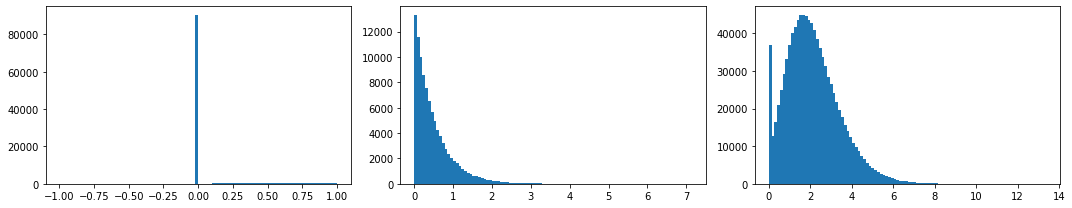

In [ ]:
# creating an example data set for input dimension n and representation dimension m
n = 1000
m = 100
reg_mtrx = generate_regulation_matrix(size1=n, size2=m, fraction_connected=0.1)
sim_data = Sim_Data(n_samples=n, n_genes=n, n_tfs=m, reg_matrix=reg_mtrx, noise=0)

fig, ax = plt.subplots(ncols=3, figsize=(15,3))
ax[0].hist(reg_mtrx.flatten(),bins=100)
ax[0].set_title('regulation matrix values')
ax[1].hist(sim_data.tf_activities.flatten(),bins=100)
ax[1].set_title('representation values')
ax[2].hist(sim_data.data.flatten(),bins=100)
ax[2].set_title('simulated data values')
plt.tight_layout()
plt.show()

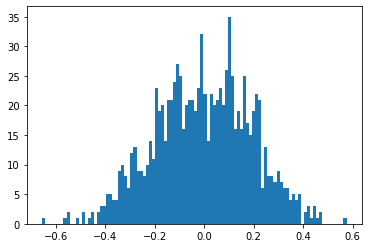

In [ ]:
# this shows the distribution from which noise is sampled in experiment 2

plt.hist(np.random.normal(scale=0.2,size=1000),bins=100)
plt.show()

---
10
---


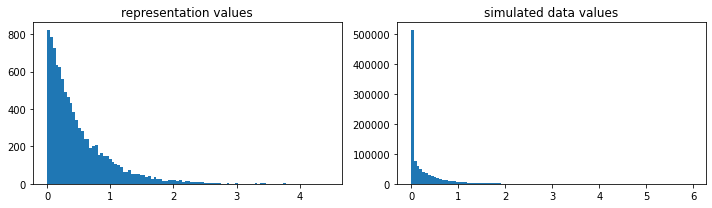

---
50
---


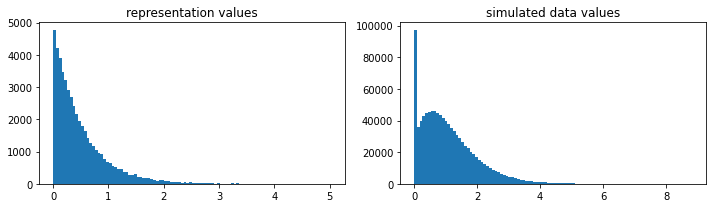

---
100
---


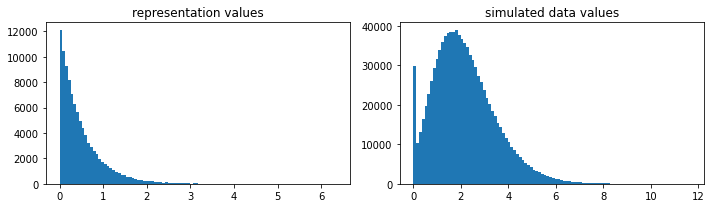

In [ ]:
n = 1000
m_range = [10, 50, 100]
N_range = 1000

# this range is probably causing problems with the losses, losses of different data value ranges are not perfectly comparable
for m in m_range:
  print('---')
  print(m)
  print('---')
  reg_mtrx = generate_regulation_matrix(size1=n, size2=m, fraction_connected=0.1)
  sim_data = Sim_Data(n_samples=n, n_genes=n, n_tfs=m, reg_matrix=reg_mtrx, noise=0)

  fig, ax = plt.subplots(ncols=2, figsize=(10,3))
  ax[0].hist(sim_data.tf_activities.flatten(),bins=100)
  ax[0].set_title('representation values')
  ax[1].hist(sim_data.data.flatten(),bins=100)
  ax[1].set_title('simulated data values')
  plt.tight_layout()
  plt.show()

# 1. Learning Rate Optimization

Optimal learning rates for input dimension 1000 were investigated via a small grid search and evaluated based on learning curves and representation correlation. This was done for two hidden dimensions, m=10 and m=100.

The following learning rates were evaluated to produce best overall performance:
  - lr = 0.001 for decoder
  - lr_rep = 0.01 for representation
  - lr_ae = 0.0001 for autoencoder/encoder

Learning curves for all tested learning rate combinations and other metrics used for this evaluation are included in the following subsections.

## Decoder and Representation

### m=100

In [ ]:
###################
# data parameters #
###################

## data dimensions

### input dimension
n = 1000
### hidden dimension
m = 100
### sample size
N = 1000

## other variables

### connectivity of the bipartite graph
fraction_connectivity=0.1
### added noise (std of normal distribution with mean 0)
noise=0.0
### correctness of the adjacency matrix (sparse matrix)
sparse_correctness=1

#######################
# training parameters #
#######################

### learning rate of the decoder
lr_range=[0.1,0.01,0.001,0.0001,0.00001]
### learning rate of the representation
lr_rep_range=[0.1,0.01,0.001,0.0001,0.00001]
### weight decay
wd=1e-5

### batch size
batch_size=32
### number of epochs (decoder and encoder, autoencoder is x2)
num_epochs=500

In [ ]:
print('running...')
count = 0
for lr in lr_range:
  print('... learning rate {}'.format(lr))
  for lr_rep in lr_rep_range:
    if count == 0:
      df = train_representation(n_genes=n, n_tfs=m, n_samples=N, fraction_connected=fraction_connectivity,
                                  noise=noise, batch_size=batch_size, num_epochs=num_epochs, lr=lr, lr_rep=lr_rep, wd=wd, plot=False)
      count = 1
    else:
      df = df.append(train_representation(n_genes=n, n_tfs=m, n_samples=N, fraction_connected=fraction_connectivity,
                                          noise=noise, batch_size=batch_size, num_epochs=num_epochs, lr=lr, lr_rep=lr_rep, wd=wd, plot=False))

#df.to_csv(direc+'learning_rates_decoder_n1000m100_history.csv',index=False)

running...
... learning rate 0.1
... learning rate 0.01
... learning rate 0.001
... learning rate 0.0001
... learning rate 1e-05


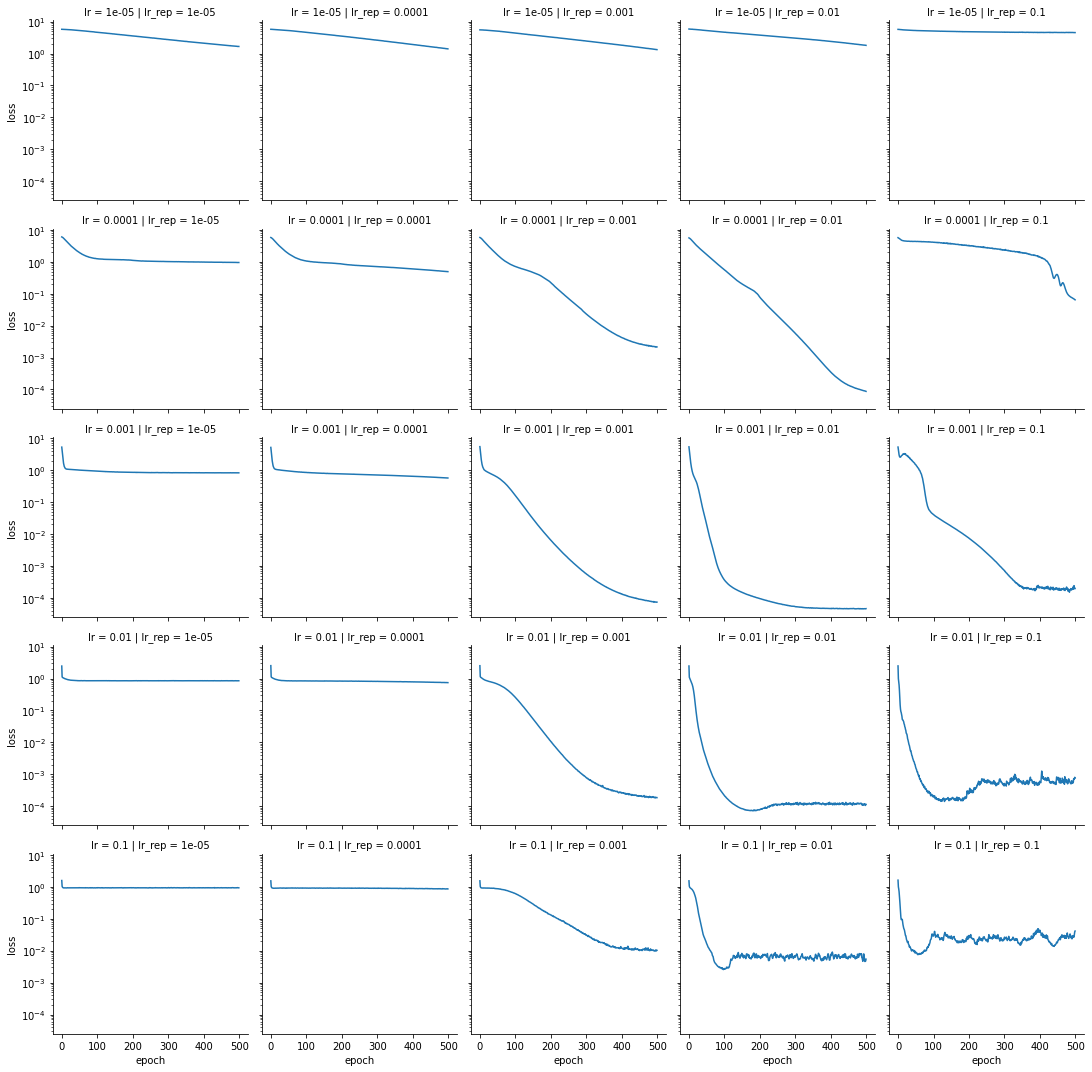

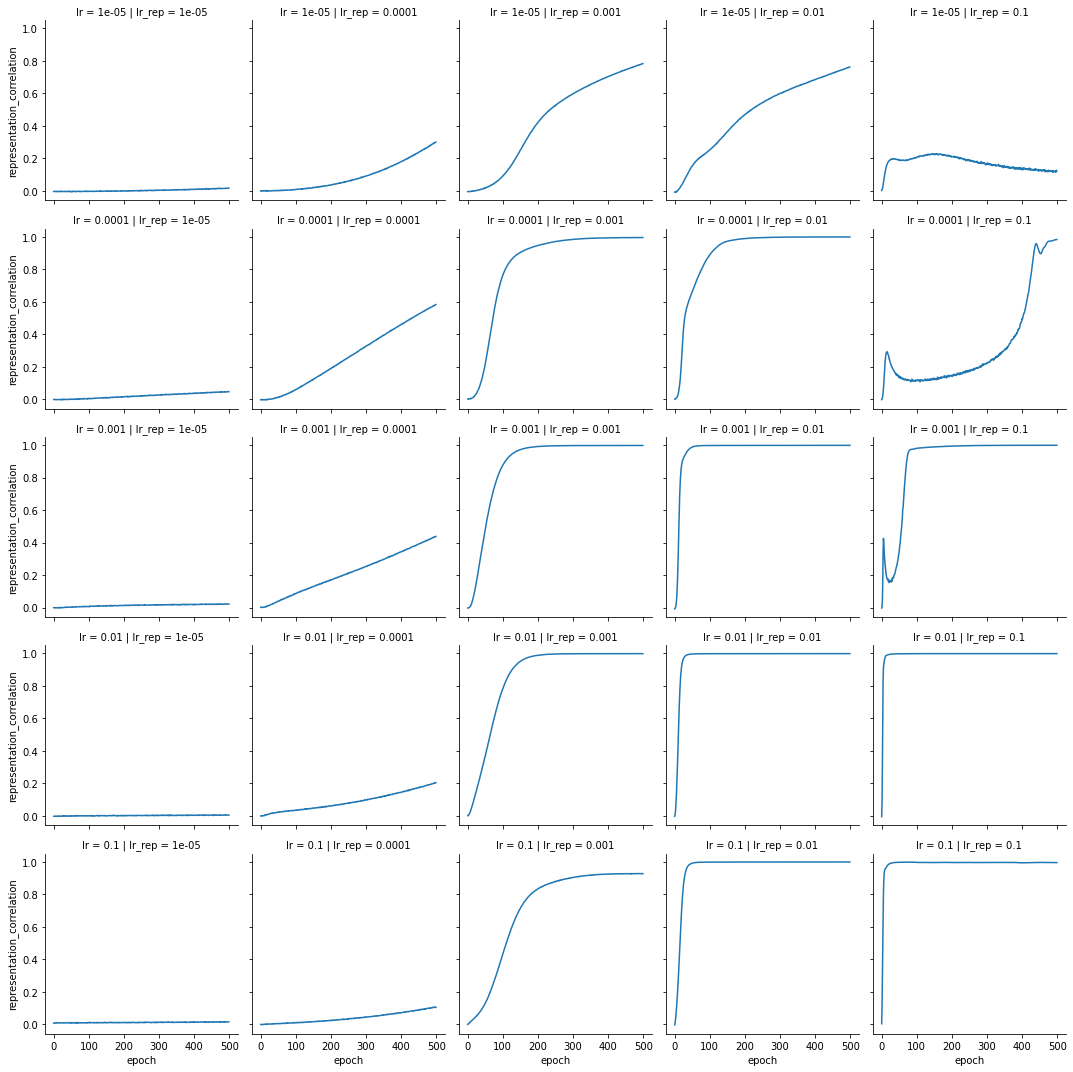

In [ ]:
g = sns.FacetGrid(df, row="lr", col="lr_rep")
g.map(sns.lineplot, "epoch", "loss")
g.set(yscale = 'log')
plt.show()

g = sns.FacetGrid(df, row="lr", col="lr_rep")
g.map(sns.lineplot, "epoch", "representation_correlation")
plt.show()

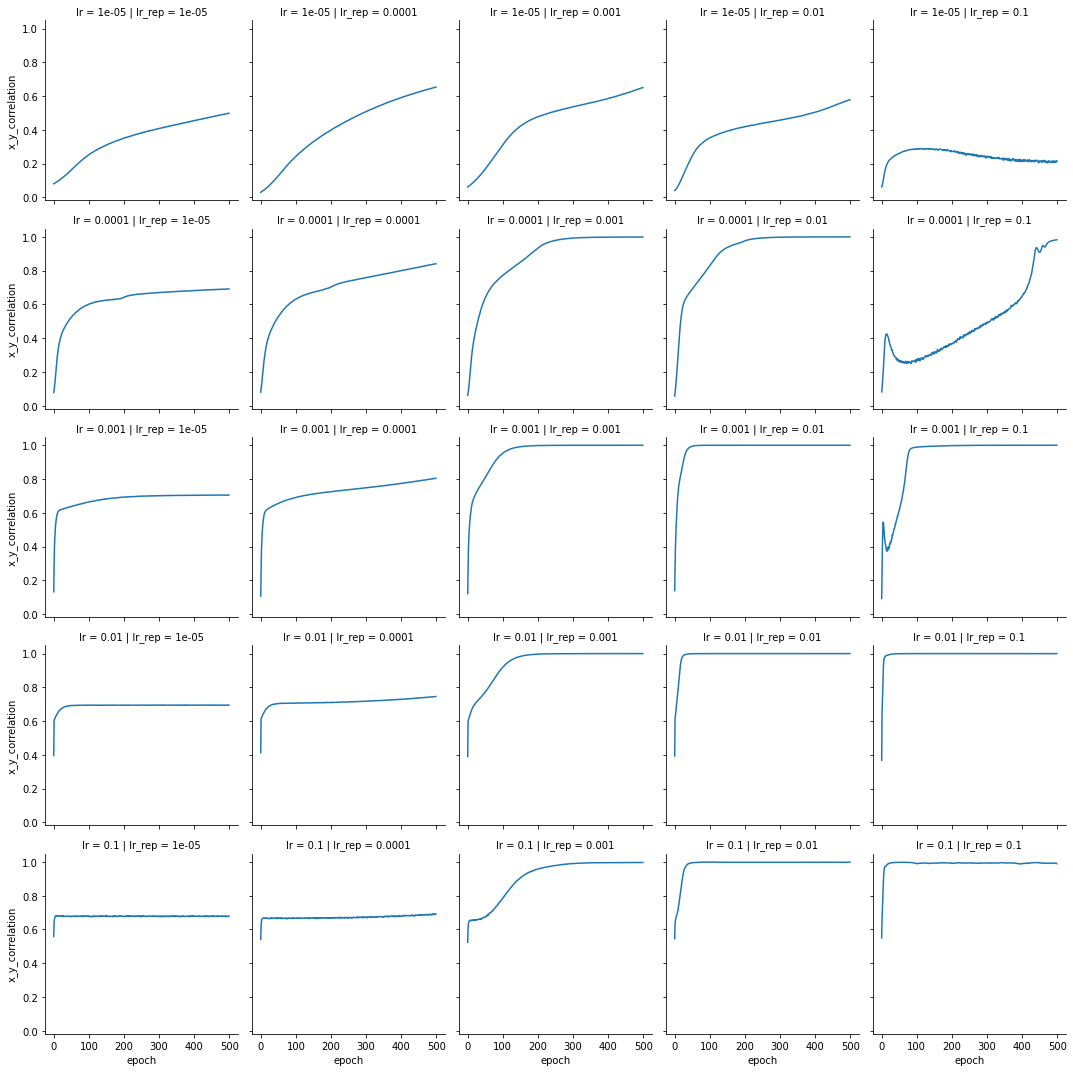

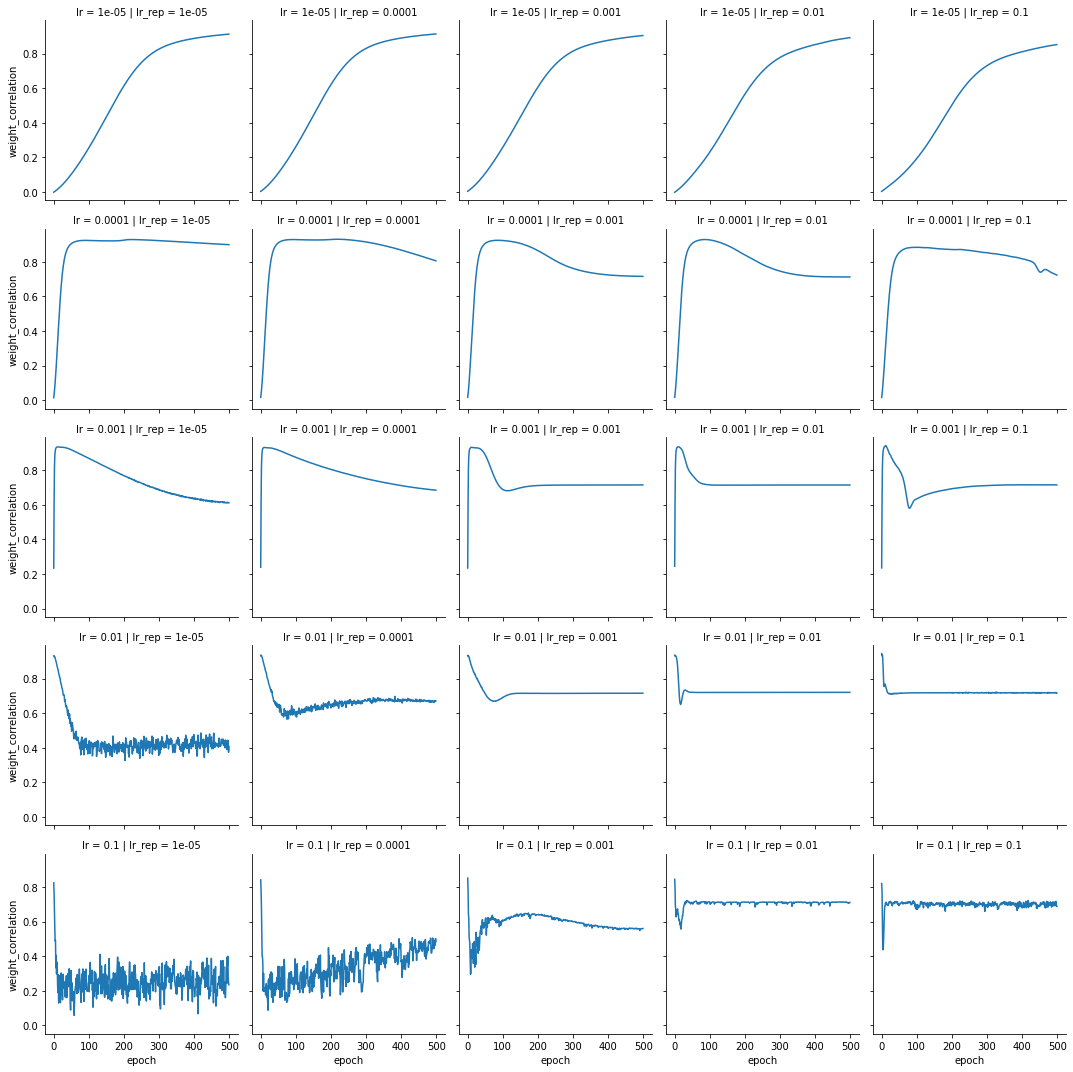

In [ ]:
g = sns.FacetGrid(df, row="lr", col="lr_rep")
g.map(sns.lineplot, "epoch", "x_y_correlation")
plt.show()

g = sns.FacetGrid(df, row="lr", col="lr_rep")
g.map(sns.lineplot, "epoch", "weight_correlation")
plt.show()

### m=10

In [ ]:
###################
# data parameters #
###################

## data dimensions

### input dimension
n = 1000
### hidden dimension
m = 10
### sample size
N = 1000

## other variables

### connectivity of the bipartite graph
fraction_connectivity=0.1
### added noise (std of normal distribution with mean 0)
noise=0.0
### correctness of the adjacency matrix (sparse matrix)
sparse_correctness=1

#######################
# training parameters #
#######################

### learning rate of the decoder
lr_range=[0.1,0.01,0.001,0.0001,0.00001]
### learning rate of the representation
lr_rep_range=[0.1,0.01,0.001,0.0001,0.00001]
### weight decay
wd=1e-5

### batch size
batch_size=32
### number of epochs (decoder and encoder, autoencoder is x2)
num_epochs=500

In [ ]:
print('running...')
count = 0
for lr in lr_range:
  print('... learning rate {}'.format(lr))
  for lr_rep in lr_rep_range:
    if count == 0:
      df = train_representation(n_genes=n, n_tfs=m, n_samples=N, fraction_connected=fraction_connectivity,
                                  noise=noise, batch_size=batch_size, num_epochs=num_epochs, lr=lr, lr_rep=lr_rep, wd=wd, plot=False)
      count = 1
    else:
      df = df.append(train_representation(n_genes=n, n_tfs=m, n_samples=N, fraction_connected=fraction_connectivity,
                                          noise=noise, batch_size=batch_size, num_epochs=num_epochs, lr=lr, lr_rep=lr_rep, wd=wd, plot=False))

#df.to_csv(direc+'learning_rates_decoder_n1000m10_history.csv',index=False)

running...
... learning rate 0.1
... learning rate 0.01
... learning rate 0.001
... learning rate 0.0001
... learning rate 1e-05


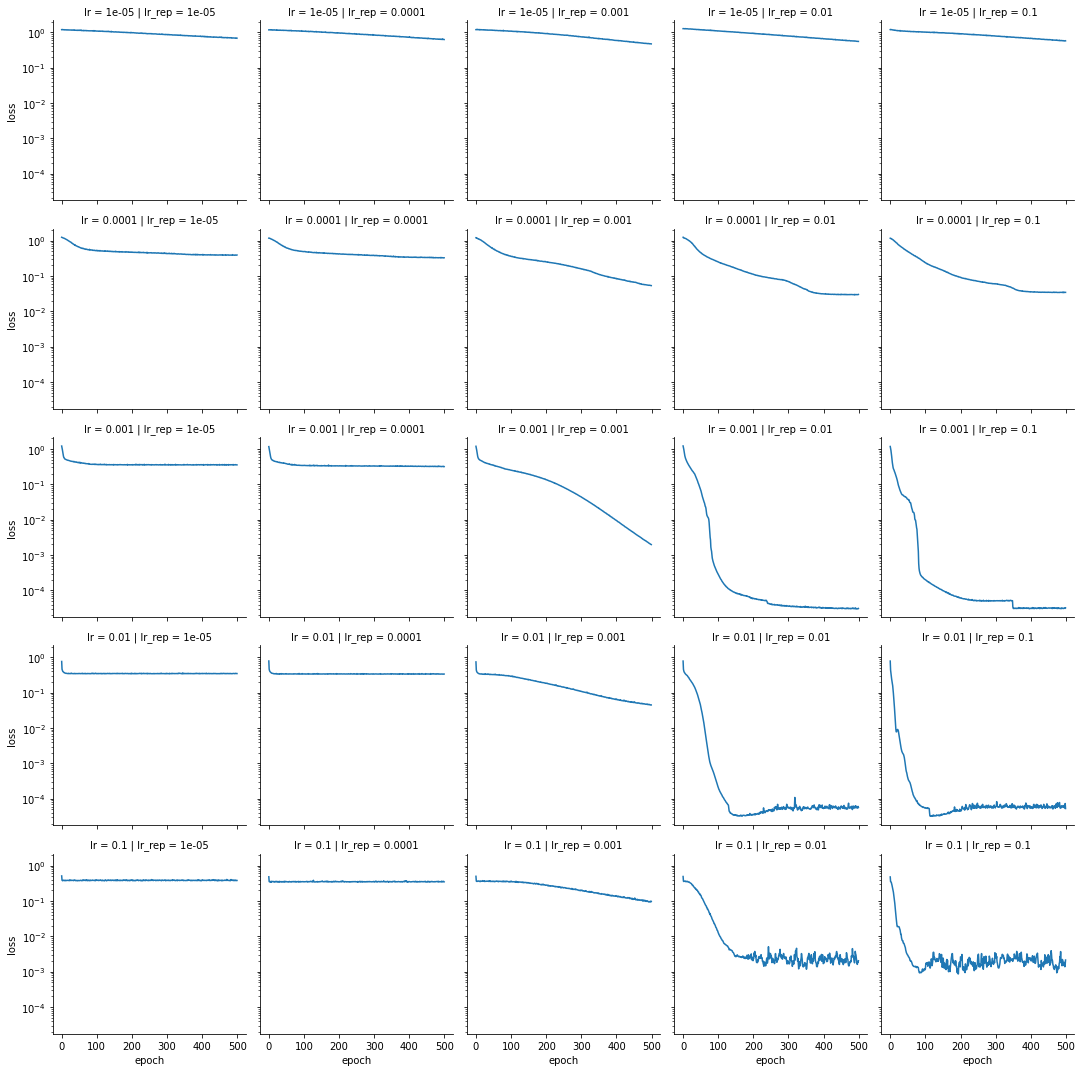

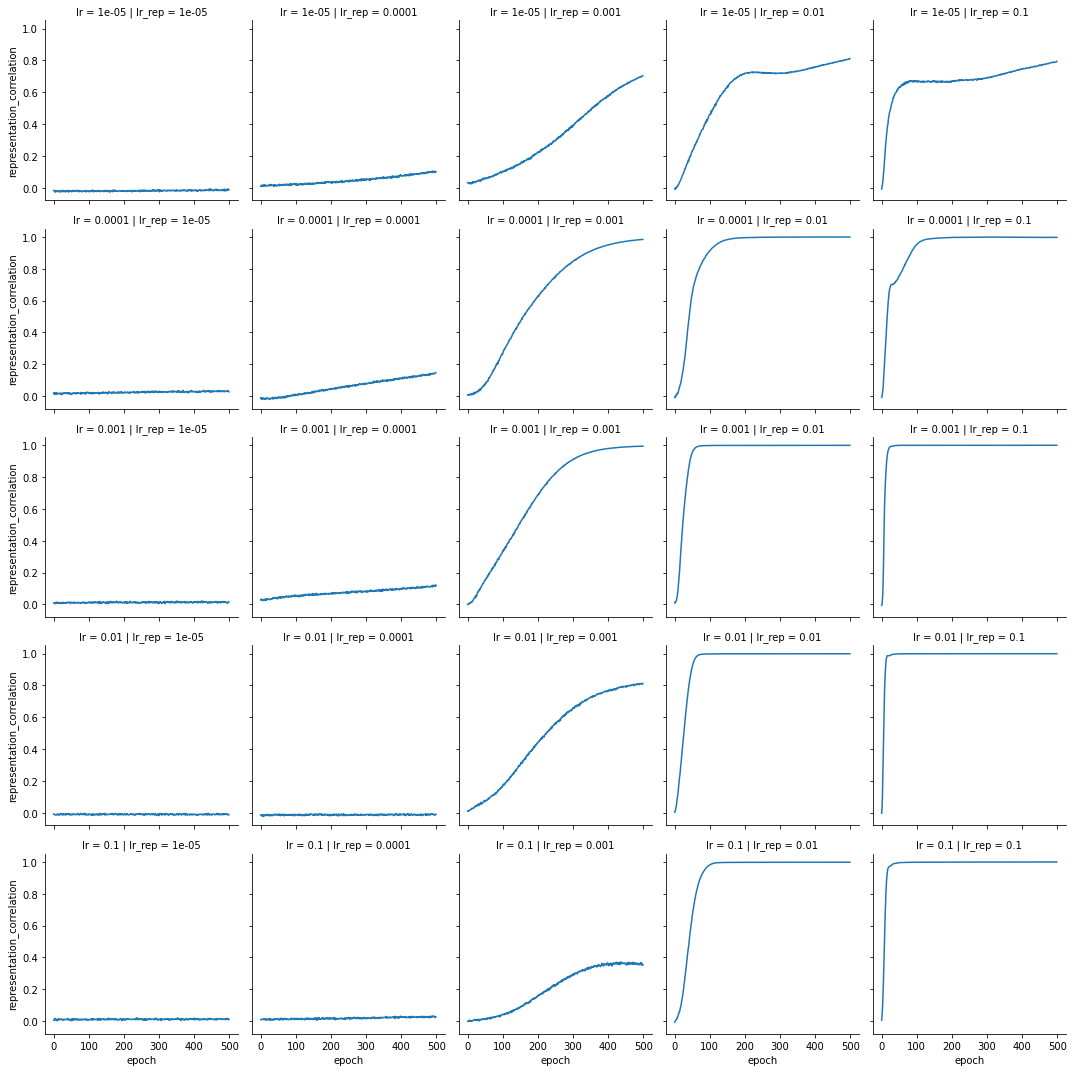

In [ ]:
g = sns.FacetGrid(df, row="lr", col="lr_rep")
g.map(sns.lineplot, "epoch", "loss")
g.set(yscale = 'log')
plt.show()

g = sns.FacetGrid(df, row="lr", col="lr_rep")
g.map(sns.lineplot, "epoch", "representation_correlation")
plt.show()

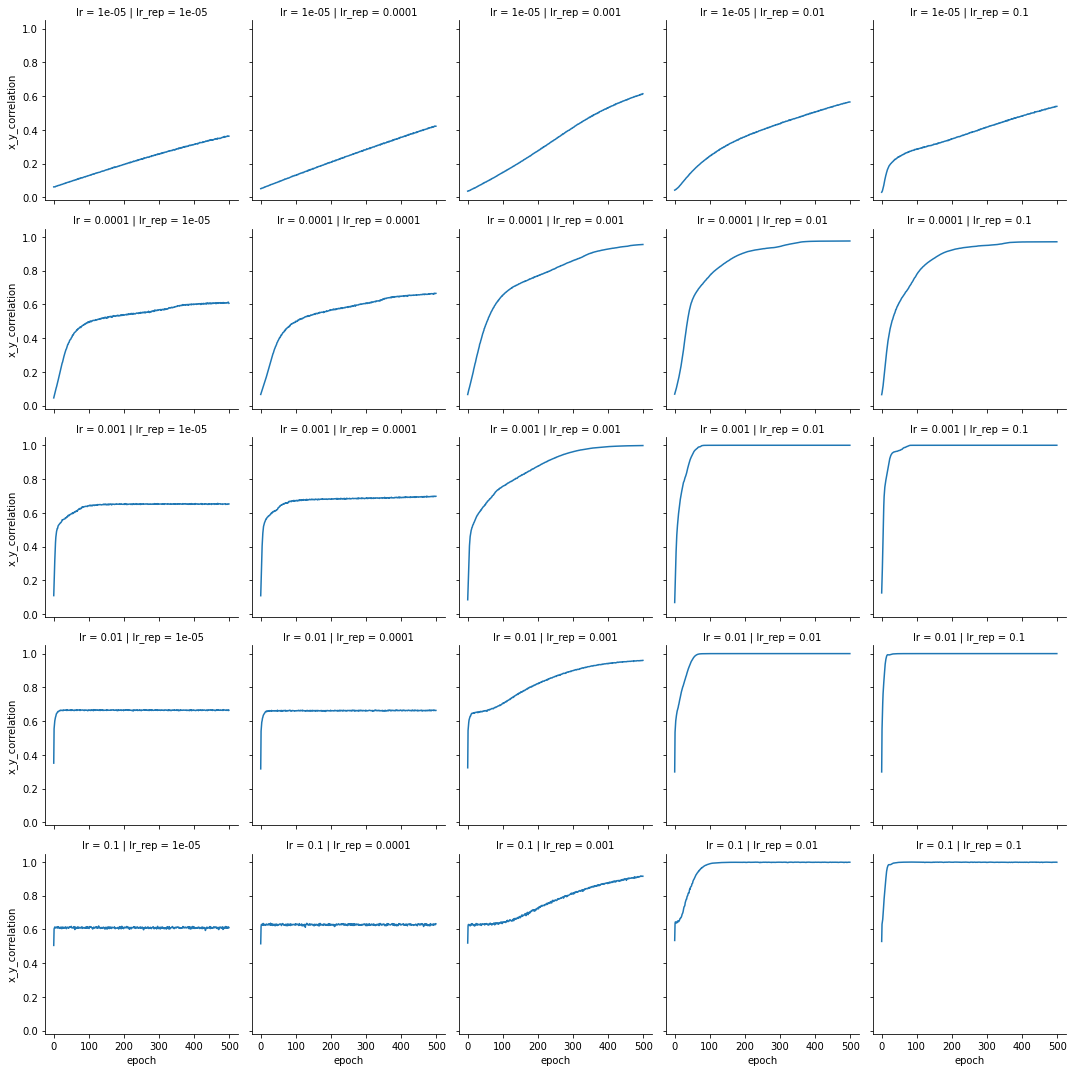

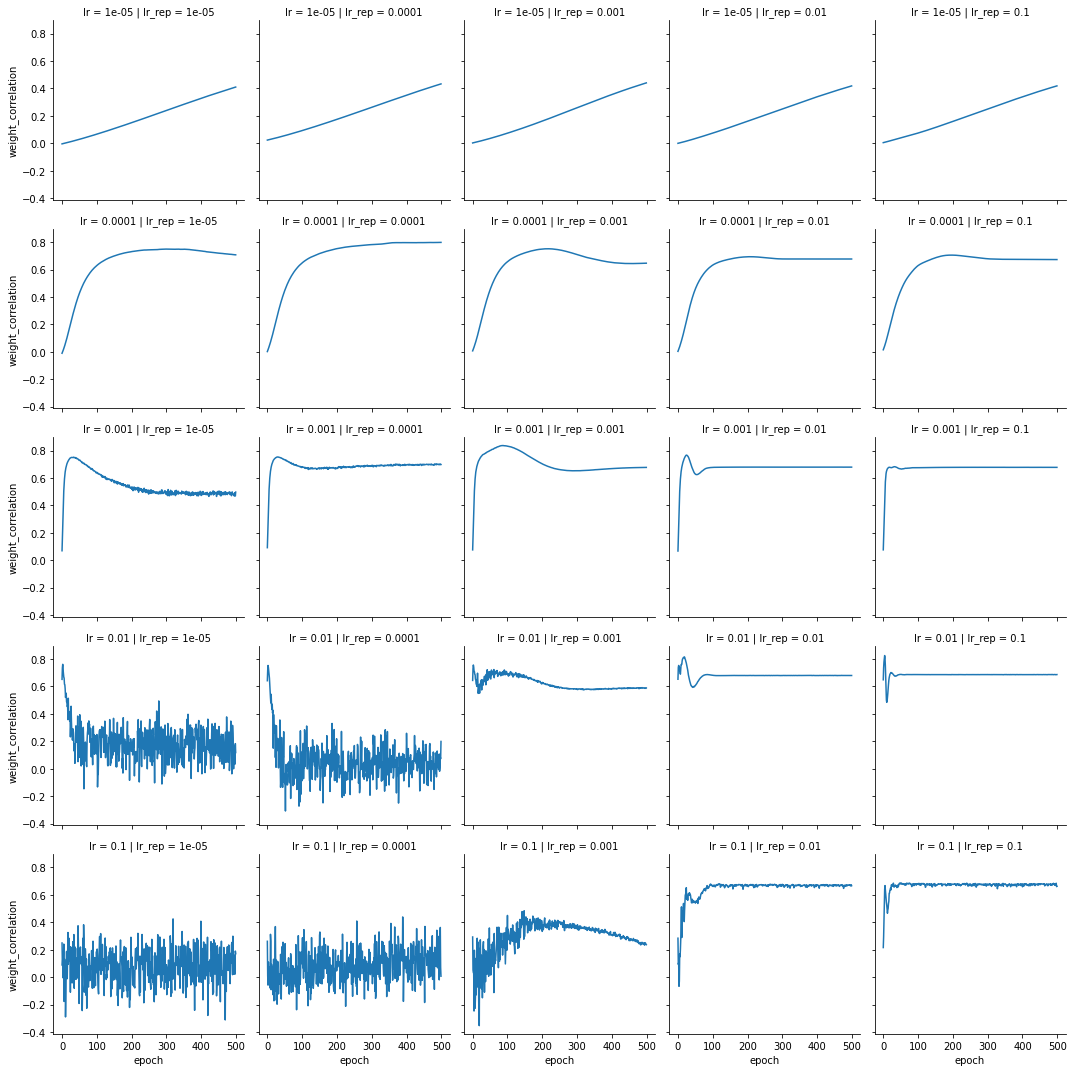

In [ ]:
g = sns.FacetGrid(df, row="lr", col="lr_rep")
g.map(sns.lineplot, "epoch", "x_y_correlation")
plt.show()

g = sns.FacetGrid(df, row="lr", col="lr_rep")
g.map(sns.lineplot, "epoch", "weight_correlation")
plt.show()

## Autoencoder

### m=100

In [ ]:
###################
# data parameters #
###################

## data dimensions

### input dimension
n = 1000
### hidden dimension
m = 100
### sample size
N = 1000

## other variables

### connectivity of the bipartite graph
fraction_connectivity=0.1
### added noise (std of normal distribution with mean 0)
noise=0.0
### correctness of the adjacency matrix (sparse matrix)
sparse_correctness=1

#######################
# training parameters #
#######################

### learning rate of the decoder
lr_range=[0.1,0.01,0.001,0.0001,0.00001]
### weight decay
wd=1e-5

### batch size
batch_size=32
### number of epochs (decoder and encoder, autoencoder is x2)
num_epochs=500

In [ ]:
print('running...')
count = 0
for lr in lr_range:
  print('... learning rate {}'.format(lr))
  if count == 0:
    df = train_autoencoder(n_genes=n, n_tfs=m, n_samples=N, fraction_connected=fraction_connectivity,
                                noise=noise, batch_size=batch_size, num_epochs=num_epochs, lr=lr, wd=wd, plot=False)
    count = 1
  else:
    df = df.append(train_autoencoder(n_genes=n, n_tfs=m, n_samples=N, fraction_connected=fraction_connectivity,
                                        noise=noise, batch_size=batch_size, num_epochs=num_epochs, lr=lr, wd=wd, plot=False))

#df.to_csv('learning_rates_AE_n1000m100_history.csv',index=False)

running...
... learning rate 0.1


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


... learning rate 0.01
... learning rate 0.001
... learning rate 0.0001
... learning rate 1e-05


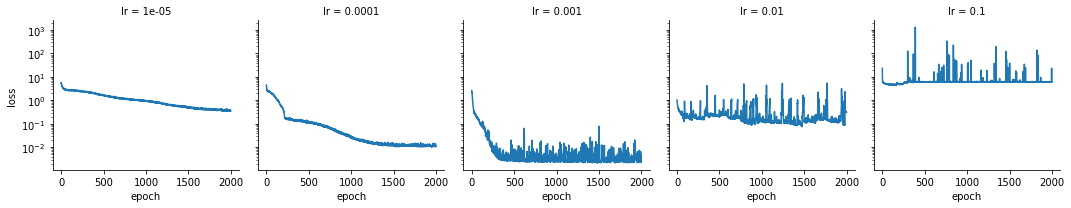

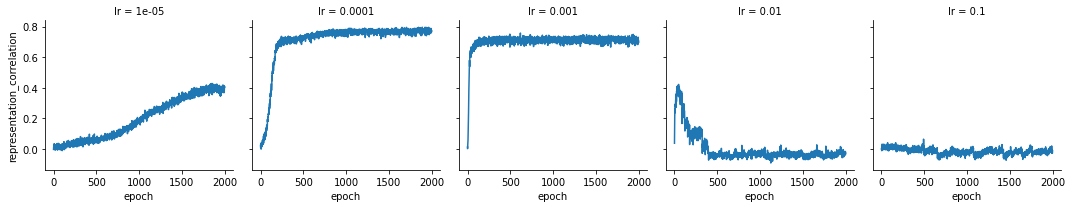

In [ ]:
g = sns.FacetGrid(df[df['loss_type'] == 'test'], col="lr")
g.map(sns.lineplot, "epoch", "loss")
g.set(yscale = 'log')
plt.show()

g = sns.FacetGrid(df[df['loss_type'] == 'test'], col="lr")
g.map(sns.lineplot, "epoch", "representation_correlation")
plt.show()

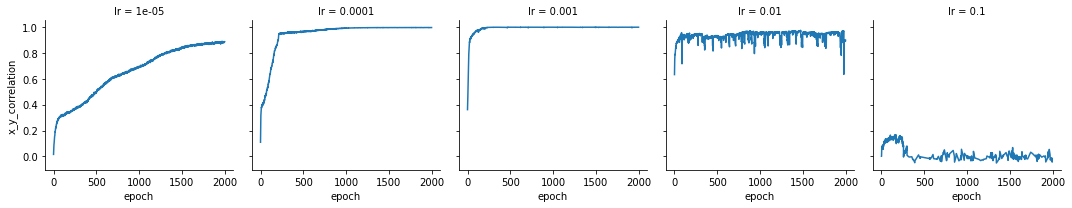

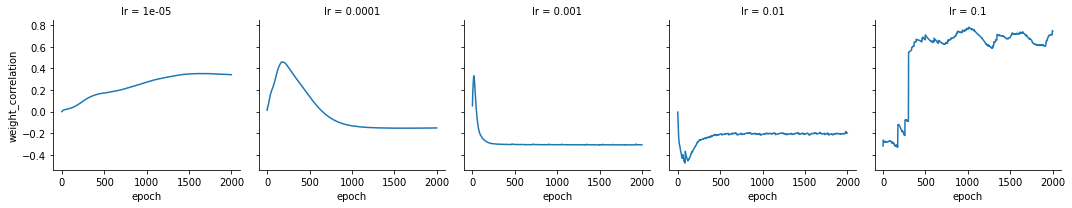

In [ ]:
g = sns.FacetGrid(df[df['loss_type'] == 'test'], col="lr")
g.map(sns.lineplot, "epoch", "x_y_correlation")
plt.show()

g = sns.FacetGrid(df[df['loss_type'] == 'test'], col="lr")
g.map(sns.lineplot, "epoch", "weight_correlation")
plt.show()

### m=10

In [ ]:
###################
# data parameters #
###################

## data dimensions

### input dimension
n = 1000
### hidden dimension
m = 10
### sample size
N = 1000

## other variables

### connectivity of the bipartite graph
fraction_connectivity=0.1
### added noise (std of normal distribution with mean 0)
noise=0.0
### correctness of the adjacency matrix (sparse matrix)
sparse_correctness=1

#######################
# training parameters #
#######################

### learning rate of the decoder
lr_range=[0.1,0.01,0.001,0.0001,0.00001]
### weight decay
wd=1e-5

### batch size
batch_size=32
### number of epochs (decoder and encoder, autoencoder is x2)
num_epochs=500

In [ ]:
print('running...')
count = 0
for lr in lr_range:
  print('... learning rate {}'.format(lr))
  if count == 0:
    df = train_autoencoder(n_genes=n, n_tfs=m, n_samples=N, fraction_connected=fraction_connectivity,
                                noise=noise, batch_size=batch_size, num_epochs=num_epochs, lr=lr, plot=False)
    count = 1
  else:
    df = df.append(train_autoencoder(n_genes=n, n_tfs=m, n_samples=N, fraction_connected=fraction_connectivity,
                                        noise=noise, batch_size=batch_size, num_epochs=num_epochs, lr=lr, plot=False))

#df.to_csv('learning_rates_AE_n1000m10_history.csv',index=False)

running...
... learning rate 0.1


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


... learning rate 0.01
... learning rate 0.001
... learning rate 0.0001
... learning rate 1e-05


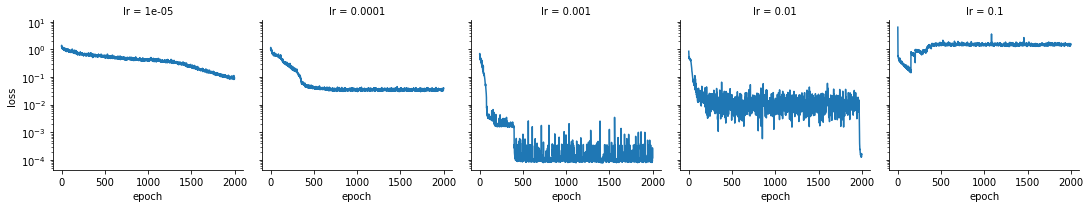

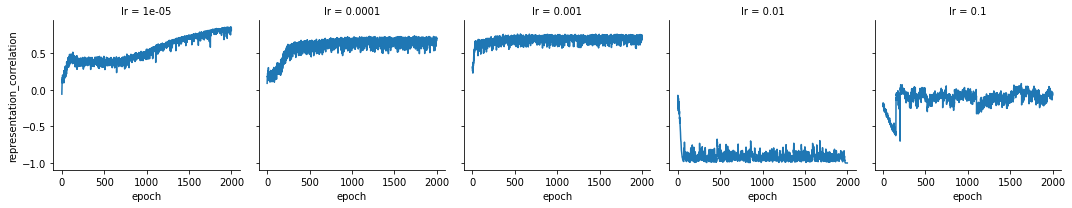

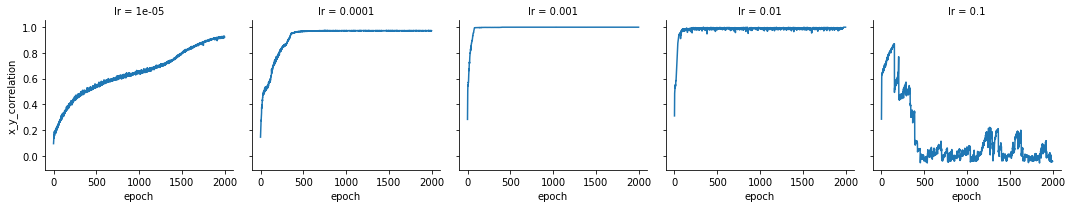

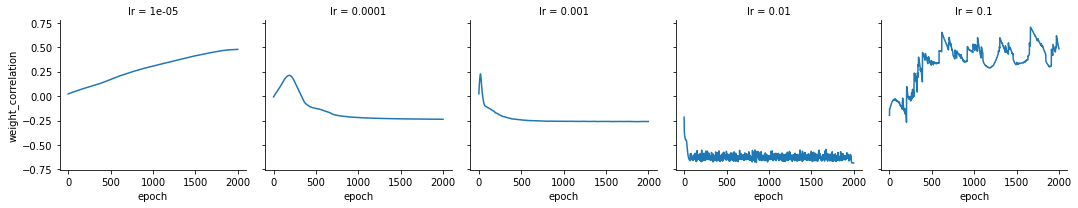

In [ ]:
g = sns.FacetGrid(df[df['loss_type'] == 'test'], col="lr")
g.map(sns.lineplot, "epoch", "loss")
g.set(yscale = 'log')
plt.show()

g = sns.FacetGrid(df[df['loss_type'] == 'test'], col="lr")
g.map(sns.lineplot, "epoch", "representation_correlation")
plt.show()

g = sns.FacetGrid(df[df['loss_type'] == 'test'], col="lr")
g.map(sns.lineplot, "epoch", "x_y_correlation")
plt.show()

g = sns.FacetGrid(df[df['loss_type'] == 'test'], col="lr")
g.map(sns.lineplot, "epoch", "weight_correlation")
plt.show()

# 2. Experiment 1

Experiment 1 investigates the relationship between the decoder load and reconstruction of the true manifold.

Three models are shown:
  - a decoder trained on its own along with the representation
  - an encoder trained with the pre-trained decoder (whose weights are fixed)
  - a naive autoencoder of the same complexity as decoder and encoder above together

While the input dimension $n$ of $X$ is fixed, variations in $\alpha_{d}$ are achieved by several different combinations of hidden dimension $m$ and sample size $N$.

For each combination of $m$ and $N$, one train and one test set is created and used to train all models. Decoder and encoder are trained for 500 epochs each, and the autoencoder is trained for 1000 epochs. This is repeated 10 times with specified random seeds. Reconstruction loss (mean squared error) and correlation between true $Z$ and representation (Pearson correlation coefficients) are reported as means with standard deviations over these 10 replicates.

### first run

In [ ]:
###################
# data parameters #
###################

## data dimensions

### input dimension
n = 1000
### list of hidden dimensions used
m_range = [10, 50, 100]
### list of sample sizes used
N_range = [100, 500, 1000, 5000]

## other variables

### connectivity of the bipartite graph
fraction_connectivity=0.1
### added noise (std of normal distribution with mean 0)
noise=0.0
### correctness of the adjacency matrix (sparse matrix)
sparse_correctness=1

#######################
# training parameters #
#######################

### learning rate of the decoder
lr=0.001
### learning rate of the representation
lr_rep=0.01
### learning rate of the encoder and autoencoder
lr_ae=0.0001
### weight decay
wd=1e-5

### batch size
batch_size=32
### number of epochs (decoder and encoder, autoencoder is x2)
num_epochs=500

##############
# replicates #
##############

# number of times to perform the experiment
n_replicates = 10
# random seeds used for replicates
random_seeds = [0,0,0,2534,2534,7,7,374,374,42]

In [ ]:
count = 0 # count for initializing output history

# loop over experiment replicates
for replicate in range(n_replicates):
  # set replicate-specific random seed for reproducibility
  set_random_seed(random_seeds[replicate])
  # loop over hidden dimensions
  for m in m_range:
    # loop over training sample sizes (test is N=100)
    for N in N_range:
      # create regulation matrix W of shape (n, m)
      regulation_matrix = generate_regulation_matrix(size1=n, size2=m, fraction_connected=fraction_connectivity)
      # generate train and test data from regulation matrix
      train_data = Sim_Data(n_samples=N, n_genes=n, n_tfs=m, reg_matrix=regulation_matrix, noise=noise)
      test_data = Sim_Data(n_samples=100, n_genes=n, n_tfs=m, reg_matrix=regulation_matrix, noise=noise)

      # train decoder and representation first and then an encoder and save performance metrics in history
      history_decoder = train_representation_and_AE_from_data(train_data, test_data, regulation_matrix, 
                                            n_samples=N, n_genes=n, n_tfs=m, num_epochs=num_epochs, lr=lr, lr_rep=lr_rep, lr_ae=lr_ae, wd=wd, bs=batch_size, plot=False)
      # train normal autoencoder
      history_AE = train_AE_from_data(train_data, test_data, regulation_matrix, n_samples=N, 
                      n_genes=n, n_tfs=m, num_epochs=num_epochs*2, lr_ae=lr_ae, wd=wd, bs=batch_size, plot=False)
      
      # create growing history dataframe
      if count == 0:
        history = history_decoder
        count = 1
      else:
        history = history.append(history_decoder)
      history = history.append(history_AE)
  # annotate replicates
  history['replicate'] = replicate

# save history to file
history.to_csv(direc+'experiment1_n1000_history.csv',index=False)

### second try without data range differences (no changing m)

In [ ]:
from datetime import datetime

###################
# data parameters #
###################

## data dimensions

### input dimension
n = 1000
### list of hidden dimensions used
m = 100
### list of sample sizes used
N_range = [25, 50, 100, 250, 500, 750, 1000, 2500, 5000, 10000, 100000]

## other variables

### connectivity of the bipartite graph
fraction_connectivity=0.1
### added noise (std of normal distribution with mean 0)
noise=0.0
### correctness of the adjacency matrix (sparse matrix)
sparse_correctness=1

#######################
# training parameters #
#######################

### learning rate of the decoder
lr=0.001
### learning rate of the representation
lr_rep=0.01
### learning rate of the encoder and autoencoder
lr_ae=0.0001
### weight decay
wd=1e-5

### batch sizes
batch_sizes = [8, 8, 16, 32, 64, 64, 128, 256, 512]
### number of epochs (decoder and encoder, autoencoder is x2)
num_epochs=250

##############
# replicates #
##############

# number of times to perform the experiment
n_replicates = 5
# random seeds used for replicates
random_seeds = [0,2534,7,374,42]

In [ ]:
for N in N_range:
  print('sample size: {}, load: {}'.format(N,alpha_d(n, m, N, n*m)))

sample size: 25, load: 0.24390243902439024
sample size: 50, load: 0.47619047619047616
sample size: 100, load: 0.9090909090909091
sample size: 250, load: 2.0
sample size: 500, load: 3.3333333333333335
sample size: 750, load: 4.285714285714286
sample size: 1000, load: 5.0
sample size: 2500, load: 7.142857142857143
sample size: 5000, load: 8.333333333333334


In [ ]:
count = 0 # count for initializing output history

# loop over experiment replicates
for replicate in range(n_replicates):
  #print('---')
  #print(replicate)
  #print('---')
  # set replicate-specific random seed for reproducibility
  set_random_seed(random_seeds[replicate])
  # loop over hidden dimensions
  for i in range(len(N_range)):
    N = N_range[i]
    batch_size = batch_sizes[i]
    #print('   {}'.format(N))
    # create regulation matrix W of shape (n, m)
    regulation_matrix = generate_regulation_matrix(size1=n, size2=m, fraction_connected=fraction_connectivity)
    # generate train and test data from regulation matrix
    train_data = Sim_Data(n_samples=N, n_genes=n, n_tfs=m, reg_matrix=regulation_matrix, noise=noise)
    test_data = Sim_Data(n_samples=100, n_genes=n, n_tfs=m, reg_matrix=regulation_matrix, noise=noise)

    # train decoder and representation first and then an encoder and save performance metrics in history
    history_decoder = train_representation_and_AE_from_data(train_data, test_data, regulation_matrix, 
                                          n_samples=N, n_genes=n, n_tfs=m, num_epochs=num_epochs, lr=lr, lr_rep=lr_rep, lr_ae=lr_ae, wd=wd, bs=batch_size, plot=False)
    # train normal autoencoder
    history_AE = train_AE_from_data(train_data, test_data, regulation_matrix, n_samples=N, 
                    n_genes=n, n_tfs=m, num_epochs=num_epochs*4, lr_ae=lr_ae, wd=wd, bs=batch_size, plot=False)
    
    # create growing history dataframe
    history = history_decoder
    history = history.append(history_AE)
    # annotate replicates
    history['replicate'] = replicate
    if replicate == 0:
      #fig,ax = plt.subplots(ncols=2, figsize=(10,3))
      #sns.lineplot(data=history[history['model']=='decoder'], x='epoch', y='loss', hue='loss_type', ax=ax[0])
      #sns.lineplot(data=history[history['model']=='AE'], x='epoch', y='loss', hue='loss_type', ax=ax[1])
      #plt.show()
    if count == 0:
      history.to_csv(direc+'experiment1_n1000_history_new.csv',index=False)
    else:
      history.to_csv(direc+'experiment1_n1000_history_new.csv',mode='a',index=False,header=False)
    count += 1

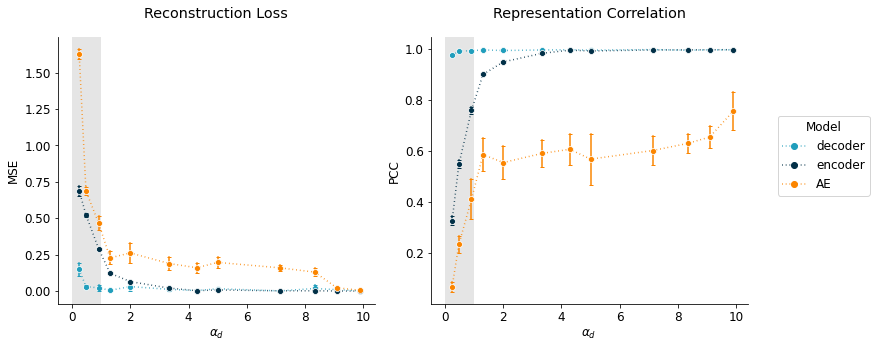

In [ ]:
my_colors = ['#8ecae6', '#219ebc', '#023047', '#ffb703', '#fb8500']

history = pd.read_csv(direc+'experiment1_n1000_history_new.csv')
n = 1000
history['load_d'] = alpha_d(n, history['n_representation'].values, history['n_samples'].values, n*history['n_representation'].values)
history['load_e'] = alpha_e(history['n_representation'].values, history['n_samples'].values, n*history['n_representation'].values)

count = 0

m = 100
for N in list(set(history['n_samples'])):
  for model in list(set(history['model'])):
    temp = history[(history['n_samples'] == N) & (history['model'] == model)]
    temp = temp[temp['loss_type'] == 'test']
    
    count_repeat = 0
    for repeat in list(set(history['replicate'])):
      temp_repeat = temp[temp['replicate'] == repeat]
      if len(temp_repeat) == 0:
        continue
      if count_repeat == 0:
        df_repeat = temp_repeat[temp_repeat['loss'] == np.min(temp_repeat['loss'].values)]
        count_repeat = 1
      else:
        df_repeat = df_repeat.append(temp_repeat[temp_repeat['loss'] == np.min(temp_repeat['loss'].values)])
    
    if count == 0:
      df = df_repeat
      count = 1
    else:
      df = df.append(df_repeat)

matplotlib.rcParams.update({'font.size': 12})
custom_palette = sns.color_palette(['#219ebc', '#023047', '#fb8500'])

fig, ax = plt.subplots(ncols=2, figsize=(12,5))
ax[0].axvspan(0, 1, alpha=0.2, color='gray',ec=None)
ax[1].axvspan(0, 1, alpha=0.2, color='gray',ec=None)
sns.lineplot(data=df, x='load_d', y='loss', hue='model', ax=ax[0], 
             palette=custom_palette, ci="sd", err_style="bars", style='model',
             markers=['o','o','o'], dashes=[(0.5,2),(0.5,2),(0.5,2)],
             err_kws={'capsize':2}, hue_order=['decoder','encoder','AE'], estimator='mean')
sns.lineplot(data=df, x='load_d', y='representation_correlation', hue='model', ax=ax[1], 
             palette=custom_palette,ci="sd", err_style="bars", style='model',
             markers=['o','o','o'], dashes=[(0.5,2),(0.5,2),(0.5,2)],
             err_kws={'capsize':2}, hue_order=['decoder','encoder','AE'])
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[1].set_xscale('log')
ax[0].set_ylabel('MSE')
ax[1].set_ylabel('PCC')
ax[0].set_xlabel(r'$\alpha_{d}$')
ax[1].set_xlabel(r'$\alpha_{d}$')
#ax[0].set_ylim([1e-20,3])
ax[0].set_title('Reconstruction Loss',y=1.05)
ax[1].set_title('Representation Correlation',y=1.05)
ax[0].get_legend().remove()
ax[1].legend(loc='center right',bbox_to_anchor=(1.02, 0.55, 0, 0),bbox_transform=fig.transFigure,title='Model')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
fig.subplots_adjust(wspace=0.2)
plt.tight_layout()
#fig.savefig(direc+'experiment1_n1000_history_load_d_pointplot_new.png',
#            bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [ ]:
history = pd.read_csv(direc+'experiment1_n1000_history_new.csv')

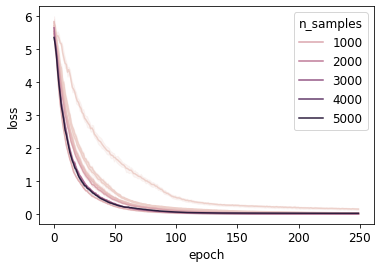

In [ ]:
sns.lineplot(data=history[(history['model']=='decoder') & (history['loss_type']=='test')], x='epoch', y='loss', hue='n_samples')
plt.show()

In [ ]:
history[(history['model']=='decoder') & (history['loss_type']=='test') & (history['epoch']==249) & (history['n_samples']==5000)]

,epoch,loss,x_y_correlation,representation_correlation,weight_correlation,loss_type,model,n_samples,n_representation,replicate
24499,249,0.039151,0.994655,0.993608,0.718647,test,decoder,5000,100,0
54499,249,0.001447,0.999770,0.998478,0.718036,test,decoder,5000,100,1
81499,249,0.052046,0.993491,0.992729,0.720735,test,decoder,5000,100,2
108499,249,0.000955,0.999820,0.998675,0.718254,test,decoder,5000,100,3
135499,249,0.007830,0.998843,0.997834,0.720814,test,decoder,5000,100,4


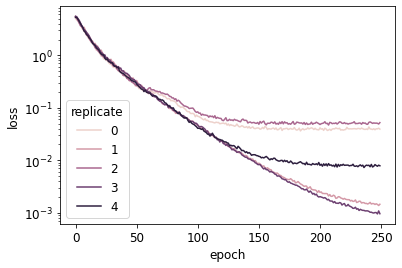

In [ ]:
sns.lineplot(data=history[(history['model']=='decoder') & (history['loss_type']=='test') & (history['n_samples']==5000)], x='epoch', y='loss', hue='replicate')
plt.yscale('log')
plt.show()

### plot in publication

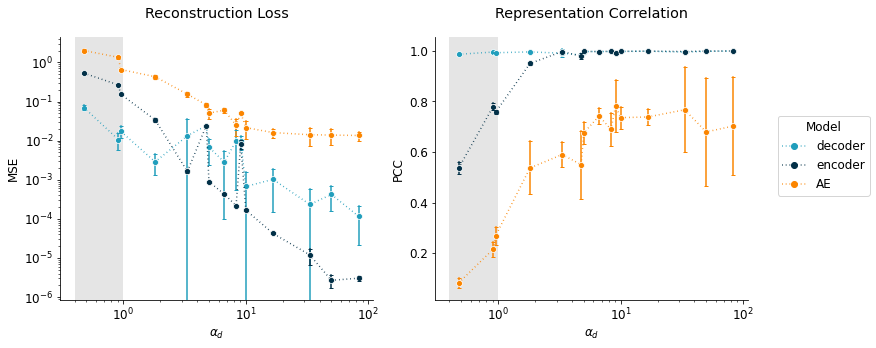

In [ ]:
my_colors = ['#8ecae6', '#219ebc', '#023047', '#ffb703', '#fb8500']

history = pd.read_csv(direc+'experiment1_n1000_history.csv')
n = 1000
history['load_d'] = alpha_d(n, history['n_representation'].values, history['n_samples'].values, n*history['n_representation'].values)
history['load_e'] = alpha_e(history['n_representation'].values, history['n_samples'].values, n*history['n_representation'].values)

history = history[history['n_representation'] != 500]

count = 0

for m in list(set(history['n_representation'])):
  for N in list(set(history['n_samples'])):
    for model in list(set(history['model'])):
      temp = history[(history['n_representation'] == m) & (history['n_samples'] == N) & (history['model'] == model)]
      temp = temp[temp['loss_type'] == 'test']
      
      count_repeat = 0
      for repeat in list(set(history['replicate'])):
        temp_repeat = temp[temp['replicate'] == repeat]
        if len(temp_repeat) == 0:
          continue
        if count_repeat == 0:
          df_repeat = temp_repeat[temp_repeat['loss'] == np.min(temp_repeat['loss'].values)]
          count_repeat = 1
        else:
          df_repeat = df_repeat.append(temp_repeat[temp_repeat['loss'] == np.min(temp_repeat['loss'].values)])
      
      if count == 0:
        df = df_repeat
        count = 1
      else:
        df = df.append(df_repeat)

matplotlib.rcParams.update({'font.size': 12})
custom_palette = sns.color_palette(['#219ebc', '#023047', '#fb8500'])

fig, ax = plt.subplots(ncols=2, figsize=(12,5))
ax[0].axvspan(4e-1, 1, alpha=0.2, color='gray',ec=None)
ax[1].axvspan(4e-1, 1, alpha=0.2, color='gray',ec=None)
sns.lineplot(data=df, x='load_d', y='loss', hue='model', ax=ax[0], 
             palette=custom_palette, ci="sd", err_style="bars", style='model',
             markers=['o','o','o'], dashes=[(0.5,2),(0.5,2),(0.5,2)],
             err_kws={'capsize':2}, hue_order=['decoder','encoder','AE'], estimator='mean')
sns.lineplot(data=df, x='load_d', y='representation_correlation', hue='model', ax=ax[1], 
             palette=custom_palette,ci="sd", err_style="bars", style='model',
             markers=['o','o','o'], dashes=[(0.5,2),(0.5,2),(0.5,2)],
             err_kws={'capsize':2}, hue_order=['decoder','encoder','AE'])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[0].set_ylabel('MSE')
ax[1].set_ylabel('PCC')
ax[0].set_xlabel(r'$\alpha_{d}$')
ax[1].set_xlabel(r'$\alpha_{d}$')
#ax[0].set_ylim([1e-20,3])
ax[0].set_title('Reconstruction Loss',y=1.05)
ax[1].set_title('Representation Correlation',y=1.05)
ax[0].get_legend().remove()
ax[1].legend(loc='center right',bbox_to_anchor=(1.02, 0.55, 0, 0),bbox_transform=fig.transFigure,title='Model')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
fig.subplots_adjust(wspace=0.2)
plt.tight_layout()
#fig.savefig(direc+'experiment1_n1000_history_load_d_pointplot_new.png',
#            bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [ ]:
print('minimum decoder representation correlation on test set: {}'.format(np.min((df[(df['model'] == 'decoder') & (df['loss_type'] == 'test')])['representation_correlation'].values)))

minimum decoder representation correlation on test set: 0.9553773090740088


### additional visualizations

Showing reconstruction loss and representation correlation for the decoder indicating $m$ and $N$ by color and marker shape, respectively.

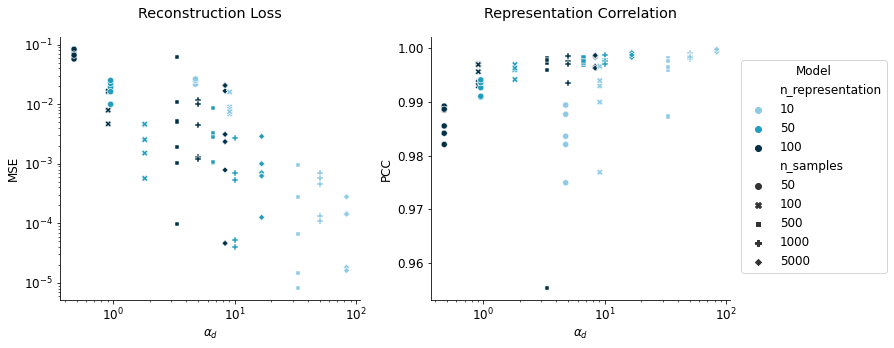

In [ ]:
df2 = df[df['model'] == 'decoder']

custom_palette = sns.color_palette(['#8ecae6', '#219ebc', '#023047'])

fig, ax = plt.subplots(ncols=2, figsize=(12,5))
sns.scatterplot(data=df2, x='load_d', y='loss', hue='n_representation', ax=ax[0], style='n_samples',palette=custom_palette)
sns.scatterplot(data=df2, x='load_d', y='representation_correlation', hue='n_representation', ax=ax[1], style='n_samples',palette=custom_palette)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[0].set_ylabel('MSE')
ax[1].set_ylabel('PCC')
ax[0].set_xlabel(r'$\alpha_{d}$')
ax[1].set_xlabel(r'$\alpha_{d}$')
ax[0].set_title('Reconstruction Loss',y=1.05)
ax[1].set_title('Representation Correlation',y=1.05)
ax[0].get_legend().remove()
ax[1].legend(loc='center right',bbox_to_anchor=(1.04, 0.52, 0, 0),bbox_transform=fig.transFigure,title='Model')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
fig.subplots_adjust(wspace=0.2)
plt.tight_layout()
#fig.savefig(direc+'experiment1_n1000_history_load_d_decoder.png',
#            bbox_inches='tight', dpi=300, transparent=True)
plt.show()

Outliers seen in the average decoder reconstruction loss for loads between 1 and 10 (seen in the publication plot) are a result of insufficient epochs for training, as can be seen in the learning curves of all replicates below.

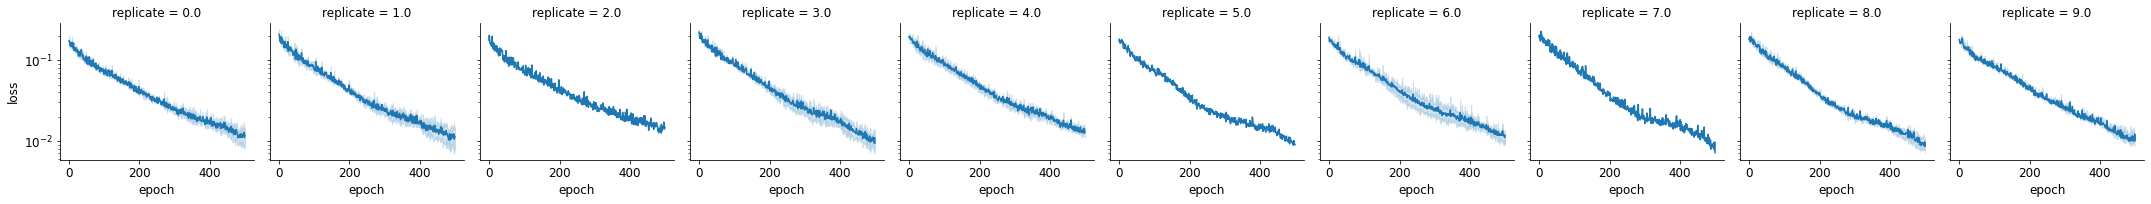

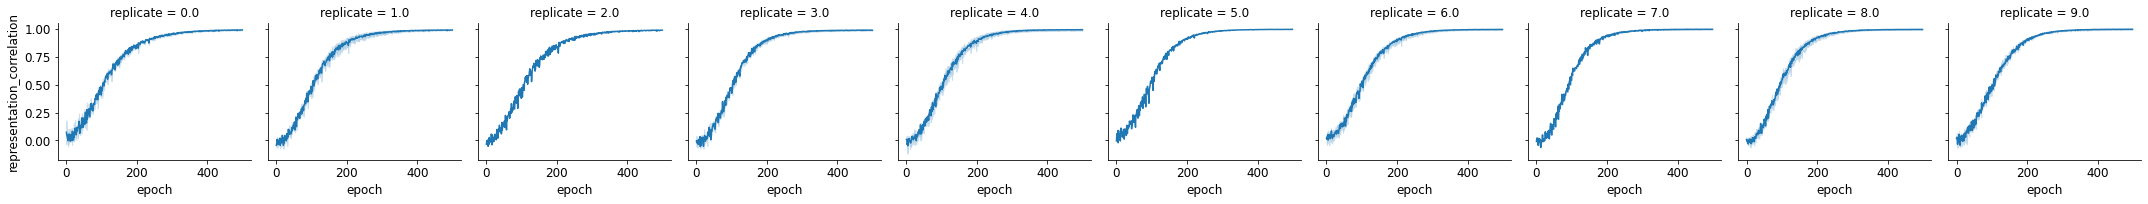

In [ ]:
test = history[(history['n_representation'] == 10) & (history['n_samples'] == 100) & (history['model'] == 'decoder') & (history['loss_type'] == 'train')]
g = sns.FacetGrid(test, col="replicate")
g.map(sns.lineplot, "epoch", "loss")
g.set(yscale = 'log')
plt.show()
g = sns.FacetGrid(test, col="replicate")
g.map(sns.lineplot, "epoch", "representation_correlation")
plt.show()

# 3. Experiment 2

Experiment 2 presents a single, more realistic, example of learning a specific manifold using representation learning.

The models used are the same as in experiment 1, with addition of a more complex autoencoder comprising an additional hidden layer in the encoder.

Three train and test sets are created with different numbers of samples in the training data. One model per model type is trained and evaluated on these data sets. Decoder and encoder are trained for 400 epochs each, the autoencoders are trained for 3000 epochs to allow for longer necessary training time.

We again report reconstruction loss and representation correlation as performance measures for the three model types.

In [ ]:
###################
# data parameters #
###################

## data dimensions

### input dimension
n = 1000
### hidden dimension
m = 100
### list of sample sizes used
N_range = [500, 1000, 5000]

## other variables

### connectivity of the bipartite graph
fraction_connectivity=0.1
### added noise (std of normal distribution with mean 0)
noise=0.2
### correctness of the adjacency matrix (sparse matrix)
sparse_correctness=1

#######################
# training parameters #
#######################

### learning rate of the decoder
lr=0.001
### learning rate of the representation
lr_rep=0.01
### learning rate of the encoder and autoencoder
lr_ae=0.0001
### weight decay
wd=1e-5

### batch size
batch_size=32
### number of epochs (decoder and encoder)
num_epochs=400
### number of epochs (autoencoder)
num_epochs_ae=3000

In [ ]:
count = 0 # count for initializing output history

# loop over training sample sizes (test is N=100)
for N in N_range:
  # create regulation matrix W of shape (n, m)
  regulation_matrix = generate_regulation_matrix(size1=n, size2=m, fraction_connected=fraction_connectivity)
  # generate train and test data from regulation matrix
  train_data = Sim_Data(n_samples=N, n_genes=n, n_tfs=m, reg_matrix=regulation_matrix, noise=noise)
  test_data = Sim_Data(n_samples=100, n_genes=n, n_tfs=m, reg_matrix=regulation_matrix, noise=noise)

  # train decoder and representation first and then an encoder and save performance metrics in history
  history_decoder = train_representation_and_AE_from_data(train_data, test_data, regulation_matrix, 
                                        n_samples=N, n_genes=n, n_tfs=m, num_epochs=num_epochs, lr=lr, lr_rep=lr_rep, lr_ae=lr_ae, wd=wd, bs=batch_size, plot=False)
  
  # train normal autoencoder
  history_AE = train_AE_from_data(train_data, test_data, regulation_matrix, n_samples=N, 
                   n_genes=n, n_tfs=m, num_epochs=num_epochs_ae, lr_ae=lr_ae, wd=wd)
  
  # train autoencoder with additional hidden layer in encoder
  history_AE2 = train_2LEnc_AE_from_data(train_data, test_data, regulation_matrix, n_samples=N, 
                   n_genes=n, n_tfs=m, num_epochs=num_epochs_ae, lr_ae=lr_ae, wd=wd, bs=batch_size, plot=False)
  
  # create growing history dataframe
  if count == 0:
    history = history_decoder
    count = 1
  else:
    history = history.append(history_decoder)
  history = history.append(history_AE)
  history = history.append(history_AE2)

# save history to file
history.to_csv(direc+'experiment2_n1000m100_noise_history.csv',index=False)

### plot in publication

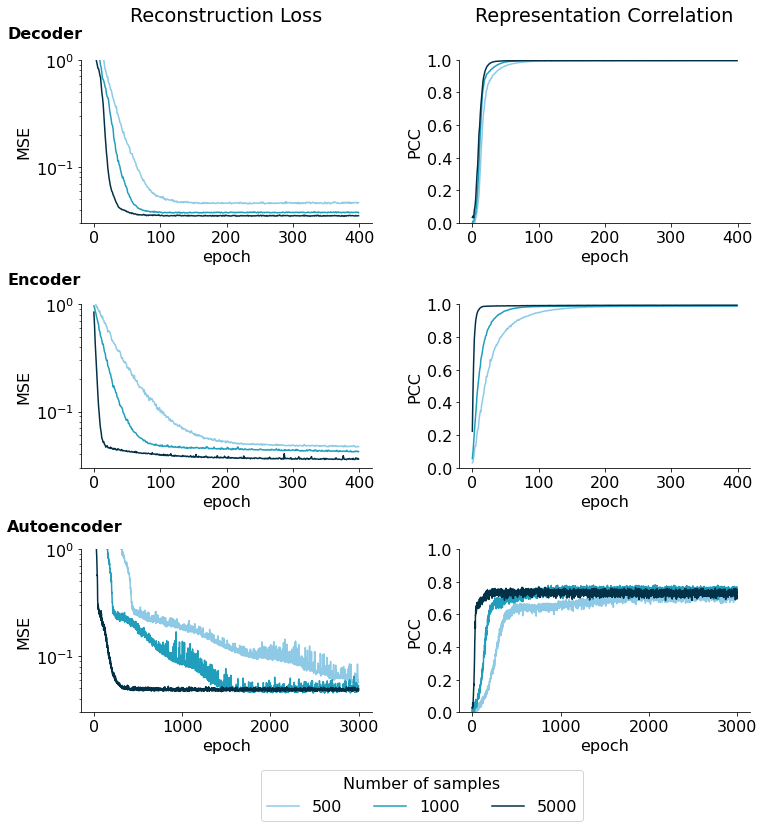

In [ ]:
my_colors = ['#8ecae6', '#219ebc', '#023047', '#ffb703', '#fb8500']

history = pd.read_csv(direc+'experiment2_n1000m100_noise_history.csv')

matplotlib.rcParams.update({'font.size': 16})
custom_palette = sns.color_palette(my_colors[0:3])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
sns.lineplot(data=history[(history['model'] == 'decoder') & (history['loss_type'] == 'test')], x='epoch', y='loss', 
             hue='n_samples', ax=ax[0][0], palette=custom_palette)
ax[0][0].set_yscale('log')
ax[0][0].set_ylabel('MSE')
ax[0][0].set_title('Reconstruction Loss',y=1.2)
sns.lineplot(data=history[(history['model'] == 'decoder') & (history['loss_type'] == 'test')], x='epoch', 
             y='representation_correlation', hue='n_samples', ax=ax[0][1],
             palette=custom_palette)
ax[0][1].set_ylabel('PCC')
ax[0][1].set_title('Representation Correlation',y=1.2)
sns.lineplot(data=history[(history['model'] == 'encoder') & (history['loss_type'] == 'test')], 
             x='epoch', y='loss', hue='n_samples', ax=ax[1][0], palette=custom_palette)
ax[1][0].set_yscale('log')
ax[1][0].set_ylabel('MSE')
sns.lineplot(data=history[(history['model'] == 'encoder') & (history['loss_type'] == 'test')], 
             x='epoch', y='representation_correlation', hue='n_samples', ax=ax[1][1], palette=custom_palette)
ax[1][1].set_ylabel('PCC')
sns.lineplot(data=history[(history['model'] == 'AE') & (history['loss_type'] == 'test')], 
             x='epoch', y='loss', hue='n_samples', ax=ax[2][0], palette=custom_palette)
ax[2][0].set_yscale('log')
ax[2][0].set_ylabel('MSE')
sns.lineplot(data=history[(history['model'] == 'AE') & (history['loss_type'] == 'test')], 
             x='epoch', y='representation_correlation', hue='n_samples', ax=ax[2][1],
             palette=custom_palette)
ax[2][1].set_ylabel('PCC')

for i in range(3):
  for ii in range(2):
    ax[i][ii].get_legend().remove()
    ax[i][ii].spines['right'].set_visible(False)
    ax[i][ii].spines['top'].set_visible(False)
    if ii == 0:
      ax[i][ii].set_ylim([3e-2,1])
    else:
      ax[i][ii].set_ylim([0,1])

handles, labels = ax[0][0].get_legend_handles_labels()
lgd = ax[0][0].legend(handles, labels, loc='lower center', ncol=len(list(set(history['n_samples']))), 
           title='Number of samples', bbox_to_anchor=(0.52, -0.01, 0, 0),bbox_transform=fig.transFigure)
text1 = fig.text(0.04,0.905, "Decoder", weight='bold')
text2 = fig.text(0.04,0.62, "Encoder", weight='bold')
text3 = fig.text(0.04,0.335, "Autoencoder", weight='bold')
fig.subplots_adjust(hspace=0.5,wspace=0.3)
fig.savefig(direc+'experiment2_n1000m100_noise_history_2.png',
            bbox_extra_artists=(lgd,text1,text2,text3), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

### additional visualizations

The following plots show reconstruction loss and representation correlation for the shallowest autoencoder and the autoencoder with an additional hidden layer in the encoder. It can be seen that even a more complex encoder is not capable of learning the desired true representation.

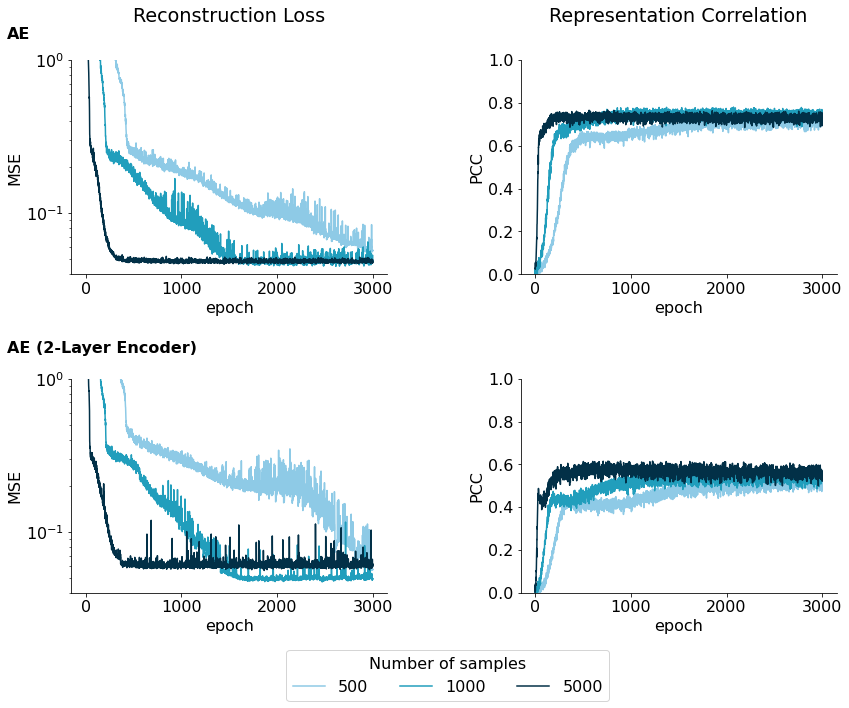

In [ ]:
my_colors = ['#8ecae6', '#219ebc', '#023047', '#ffb703', '#fb8500']

history = pd.read_csv(direc+'experiment2_n1000m100_noise_history.csv')

matplotlib.rcParams.update({'font.size': 16})
custom_palette = sns.color_palette(my_colors[0:3])

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
sns.lineplot(data=history[(history['model'] == 'AE') & (history['loss_type'] == 'test')], x='epoch', y='loss', 
             hue='n_samples', ax=ax[0][0], palette=custom_palette)
ax[0][0].set_yscale('log')
ax[0][0].set_ylabel('MSE')
ax[0][0].set_title('Reconstruction Loss',y=1.15)
sns.lineplot(data=history[(history['model'] == 'AE') & (history['loss_type'] == 'test')], x='epoch', 
             y='representation_correlation', hue='n_samples', ax=ax[0][1],
             palette=custom_palette)
ax[0][1].set_ylabel('PCC')
ax[0][1].set_title('Representation Correlation',y=1.15)
sns.lineplot(data=history[(history['model'] == 'AE_2LayerEncoder') & (history['loss_type'] == 'test')], 
             x='epoch', y='loss', hue='n_samples', ax=ax[1][0], palette=custom_palette)
ax[1][0].set_yscale('log')
ax[1][0].set_ylabel('MSE')
sns.lineplot(data=history[(history['model'] == 'AE_2LayerEncoder') & (history['loss_type'] == 'test')], 
             x='epoch', y='representation_correlation', hue='n_samples', ax=ax[1][1], palette=custom_palette)
ax[1][1].set_ylabel('PCC')


for i in range(2):
  for ii in range(2):
    ax[i][ii].get_legend().remove()
    ax[i][ii].spines['right'].set_visible(False)
    ax[i][ii].spines['top'].set_visible(False)
    if ii == 0:
      ax[i][ii].set_ylim([4e-2,1])
    else:
      ax[i][ii].set_ylim([0,1])

handles, labels = ax[0][0].get_legend_handles_labels()
lgd = ax[0][0].legend(handles, labels, loc='lower center', ncol=len(list(set(history['n_samples']))), 
           title='Number of samples', bbox_to_anchor=(0.53, -0.08, 0, 0),bbox_transform=fig.transFigure)
text1 = fig.text(0.02,0.85, "AE", weight='bold')
text2 = fig.text(0.02,0.415, "AE (2-Layer Encoder)", weight='bold')
fig.subplots_adjust(hspace=-1.1,wspace=-0.5)
fig.tight_layout()
fig.savefig(direc+'experiment2_n1000m100_noise_history_3.png',
            bbox_extra_artists=(lgd,text1,text2,text3), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

# 4. Experiment 3

Can training speed and accuracy be improved by starting the representations from a PCA?

In [ ]:
from sklearn.decomposition import PCA

def extract_pca_features(data,m_dim):
  pca_data = data
  pca = PCA(n_components=m_dim)
  pca.fit(pca_data)
  projected = pca.fit_transform(pca_data)
  return projected

class RepresentationLayer(torch.nn.Module):
  '''
  Implements a representation layer, that accumulates pytorch gradients.
  To update representation, the pytorch framework does not work well, so
  the module comes with it's own SGD update (self.update(lr,mom,...)).
  Do not forget to call zero_grad after an epoch
  '''
  def __init__(self, nrep, nsample,
               pca_init=False,
               data=None,
               rep_activity=(1.,1.),      # Normal distribution mean and stddev
               norm=True                  # Normalize representation
              ):
    super(RepresentationLayer, self).__init__()
    self.nrep=nrep
    self.nsample=nsample
    self.mean, self.stddev = rep_activity[0],rep_activity[1]
    self.norm = norm
    self.init_rep(rep_activity[0],rep_activity[1],pca_init,data)
    self.dz = None

  def init_rep(self,mean,stddev,pca_init,data):
    # Generate random activities
    if pca_init:
      # make pca from data
      self.z = torch.nn.Parameter(torch.tensor(extract_pca_features(data,self.nrep), dtype=torch.float32, requires_grad=True))
    else:
      self.z = torch.nn.Parameter(torch.normal(mean,stddev,size=(self.nsample,self.nrep), requires_grad=True))
    #print(self.z.dtype)
    self.clamp()

  def clamp(self):
    with torch.no_grad():
      if self.norm:
        self.z.clamp_(min=0)
        norm = 1./self.z.mean()
        self.z.mul_(norm)
      else:
        self.z.clamp_(min=0)

  def zero_grad(self):
    if self.z.grad is not None:
      self.z.grad.detach_()
      self.z.grad.zero_()

  def fix(self):
    self.z.requires_grad = False

  def unfix(self):
    self.z.requires_grad = True

  def forward(self, idx):
    if idx is None:
      return self.z
    else:
      return self.z[idx]

  # Index can be whatever it can be for a torch.tensor (e.g. tensor of idxs)
  def __getitem__(self,index):
    return self.h[index] # what is h?

  def update(self,idx,lr=0.001,mom=0.9,wd=None):
    device = self.z.device
    if self.dz is None:
      self.dz = torch.zeros(self.z.size()).to(device)
    with torch.no_grad():
      # Update z
      # dz(k,j) = sum_i grad(k,i) w(i,j) step(z(j))
      self.dz[idx] = self.dz[idx].mul(mom) - self.z.grad[idx].mul(lr)
      if wd is not None:
        self.dz[idx] -= wd*self.z[idx]
      self.z[idx] += self.dz[idx]
      self.clamp()

def train_representation_and_AE_from_data(train_data, test_data, regulation_matrix, n_samples, n_genes, n_tfs, num_epochs, lr, lr_rep, lr_ae, wd, bs, plot=True):
  '''
  wrapper function for training decoder and representation first
  and then training an autoencoder with this fixed decoder
  on pre-defined data
  '''
  # create dataloader objects and sparse matrix
  train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=bs,
                                          shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=bs,
                                          shuffle=True)
  sparse_mtrx = create_sparse_matrix(regulation_matrix, 1).to(device)

  # initialize representation and decoder
  representation = RepresentationLayer(n_tfs,n_samples).to(device)
  test_representation = RepresentationLayer(n_tfs,100).to(device)
  decoder = torch.nn.Sequential(
    SparseLinear(n_tfs,n_genes,sparse_mtrx),
    torch.nn.ReLU(inplace=True)).to(device)
  decoder_optimizer = torch.optim.Adam(decoder.parameters(),
                                      lr=lr,
                                      weight_decay=wd)
  criterion = torch.nn.MSELoss(reduction='mean')

  # train representation
  decoder, history_decoder = train_representation_alone(decoder=decoder, decoder_optimizer=decoder_optimizer, representation=representation, test_representation=test_representation, 
                                       sim_loader=train_loader, test_loader=test_loader, criterion=criterion, lr_rep=lr_rep, regulation_matrix=regulation_matrix, num_epochs=num_epochs, plot=plot)
  
  history_decoder['rep_init'] = 'normal'
  return history_decoder

def train_representation_and_AE_from_data_pca(train_data, test_data, regulation_matrix, n_samples, n_genes, n_tfs, num_epochs, lr, lr_rep, lr_ae, wd, bs, plot=True):
  '''
  wrapper function for training decoder and representation first
  and then training an autoencoder with this fixed decoder
  on pre-defined data
  '''
  # create dataloader objects and sparse matrix
  train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=bs,
                                          shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=bs,
                                          shuffle=True)
  sparse_mtrx = create_sparse_matrix(regulation_matrix, 1).to(device)

  # initialize representation and decoder
  representation = RepresentationLayer(n_tfs,n_samples,pca_init=True,data=train_data.data).to(device)
  test_representation = RepresentationLayer(n_tfs,100).to(device)
  decoder = torch.nn.Sequential(
    SparseLinear(n_tfs,n_genes,sparse_mtrx),
    torch.nn.ReLU(inplace=True)).to(device)
  decoder_optimizer = torch.optim.Adam(decoder.parameters(),
                                      lr=lr,
                                      weight_decay=wd)
  criterion = torch.nn.MSELoss(reduction='mean')

  # train representation
  decoder, history_decoder = train_representation_alone(decoder=decoder, decoder_optimizer=decoder_optimizer, representation=representation, test_representation=test_representation, 
                                       sim_loader=train_loader, test_loader=test_loader, criterion=criterion, lr_rep=lr_rep, regulation_matrix=regulation_matrix, num_epochs=num_epochs, plot=plot)
  
  history_decoder['rep_init'] = 'PCA'
  return history_decoder

In [ ]:
###################
# data parameters #
###################

## data dimensions

### input dimension
n = 1000
### list of hidden dimensions used
m = 100
### list of sample sizes used
N = 1000

## other variables

### connectivity of the bipartite graph
fraction_connectivity=0.1
### added noise (std of normal distribution with mean 0)
noise=0.0
### correctness of the adjacency matrix (sparse matrix)
sparse_correctness=1

#######################
# training parameters #
#######################

### learning rate of the decoder
lr=0.001
### learning rate of the representation
lr_rep=0.01
### learning rate of the encoder and autoencoder
lr_ae=0.0001
### weight decay
wd=1e-5

### batch size
batch_size=32
### number of epochs (decoder and encoder, autoencoder is x2)
num_epochs=500

##############
# replicates #
##############

# number of times to perform the experiment
n_replicates = 10
# random seeds used for replicates
random_seeds = [0,0,0,2534,2534,7,7,374,374,42]

count = 0 # count for initializing output history

# loop over experiment replicates
for replicate in range(n_replicates):
  print(replicate)
  # set replicate-specific random seed for reproducibility
  set_random_seed(random_seeds[replicate])
  # create regulation matrix W of shape (n, m)
  regulation_matrix = generate_regulation_matrix(size1=n, size2=m, fraction_connected=fraction_connectivity)
  # generate train and test data from regulation matrix
  train_data = Sim_Data(n_samples=N, n_genes=n, n_tfs=m, reg_matrix=regulation_matrix, noise=noise)
  test_data = Sim_Data(n_samples=100, n_genes=n, n_tfs=m, reg_matrix=regulation_matrix, noise=noise)

  # train decoder and representation first and then an encoder and save performance metrics in history
  history_decoder = train_representation_and_AE_from_data(train_data, test_data, regulation_matrix, 
                                        n_samples=N, n_genes=n, n_tfs=m, num_epochs=num_epochs, lr=lr, lr_rep=lr_rep, lr_ae=lr_ae, wd=wd, bs=batch_size, plot=False)
  
  history_decoder_pca = train_representation_and_AE_from_data_pca(train_data, test_data, regulation_matrix, 
                                        n_samples=N, n_genes=n, n_tfs=m, num_epochs=num_epochs, lr=lr, lr_rep=lr_rep, lr_ae=lr_ae, wd=wd, bs=batch_size, plot=False)
  
  history_decoder['replicate'] = replicate
  history_decoder_pca['replicate'] = replicate
  # create growing history dataframe
  if count == 0:
    history = history_decoder
    count = 1
  else:
    history = history.append(history_decoder)
  history = history.append(history_decoder_pca)

0
1
2
3
4
5
6
7
8
9


log-scaled decoder losses


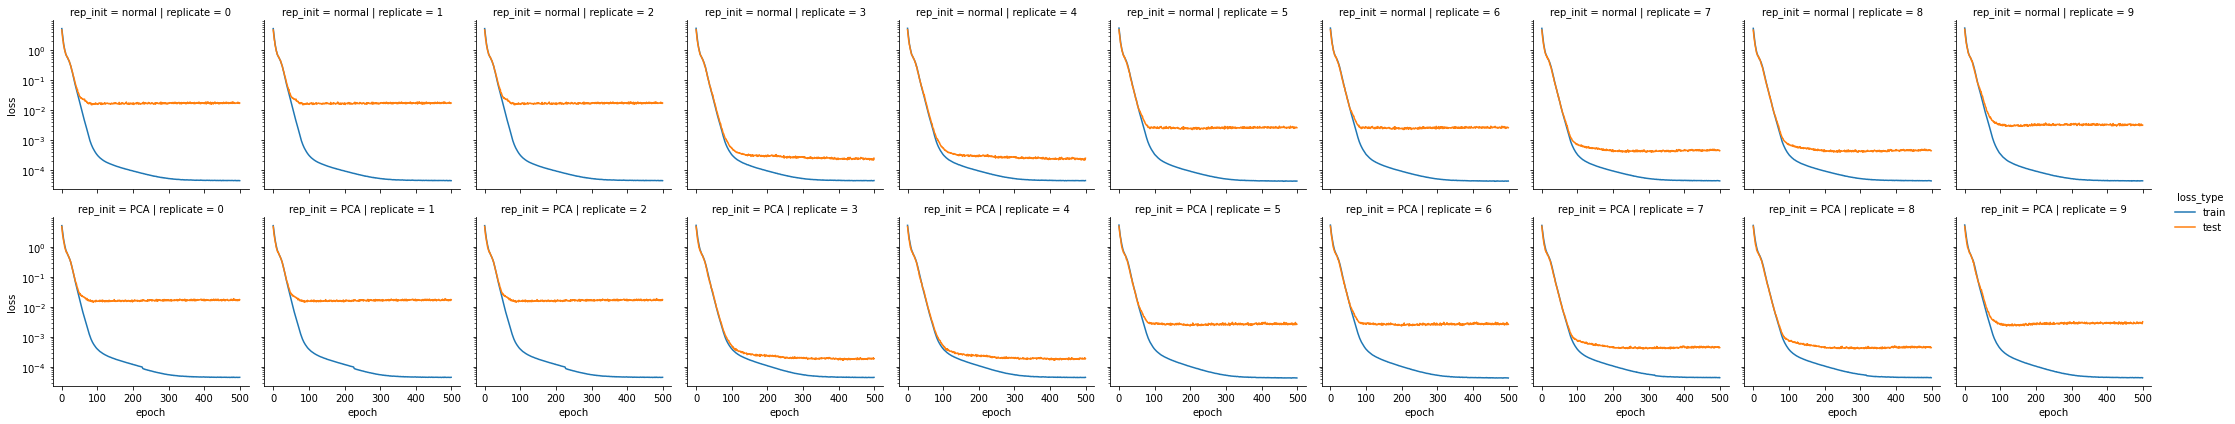

representation correlations


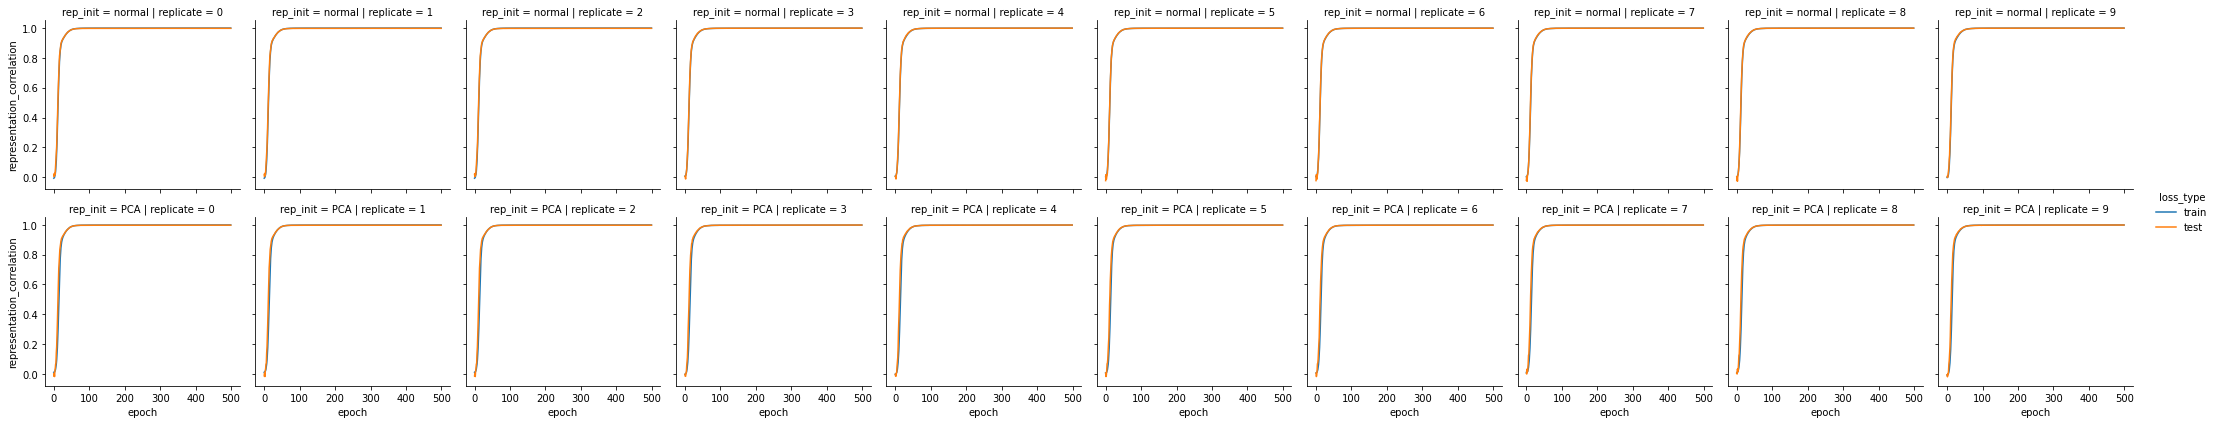

In [ ]:
print('log-scaled decoder losses')
g = sns.FacetGrid(history, row='rep_init', col="replicate", hue="loss_type")
g.map(sns.lineplot, "epoch", "loss")
g.set(yscale = 'log')
g.add_legend()
plt.show()

print('representation correlations')
g = sns.FacetGrid(history, row='rep_init', col="replicate", hue="loss_type")
g.map(sns.lineplot, "epoch", "representation_correlation")
g.add_legend()
plt.show()